In [137]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymaid
import logging
import random
from graspologic.match import graph_match
from graspologic.simulations import er_np
from graspologic.utils import is_unweighted
from pkg.platy import _get_folder, load_connectome_normal_lcc_annotations_v2, load_connectome_normal_lcc_annotations_v3, load_connectome_lcc_normal_adj, load_left_adj, load_right_adj, load_left_adj_labels_with_class_v2, load_right_adj_labels_with_class_v2, load_head_adj_labels_with_class_v2, load_pygidium_adj_labels_with_class_v2, load_0_adj, load_1_adj_labels_with_class_v2, load_2_adj_labels_with_class_v2, load_3_adj_labels_with_class_v2, load_left_adj_labels_with_class_v3, load_right_adj_labels_with_class_v3

Grab Nadine's pairs: these are the true pairs

In [4]:
folder = "/Users/kareefullah/Desktop/naomi-pairwise.xlsx"
true_df = pd.read_excel(folder, dtype=str)

#need to subset true_pairs for the pairs that have left and right entries in their row
true_pairs = true_df[["skid-ID LEFT", "skid-ID RIGHT"]]

#subset true_pairs to not include pairs of neurons that do not have a match
true_pairs = true_pairs[~true_pairs.isnull().any(axis=1)].reset_index()
left_true = list(true_pairs["skid-ID LEFT"])
right_true = list(true_pairs["skid-ID RIGHT"])
true_pairs

,index,skid-ID LEFT,skid-ID RIGHT
0,0,7501,25010
1,1,10536,26163
2,2,6743,23921
3,3,151847,27064
4,4,12115,27917
...,...,...,...
288,669,1326008,1359694
289,670,1717565,1330831
290,671,493317,1299058
291,672,1855933,111948


Load in the left and right adjacency matrices (each neuron in both adjacencies has an associated class label)

In [151]:
left_adj, left_labels = load_left_adj_labels_with_class_v3()
right_adj, right_labels = load_right_adj_labels_with_class_v3()

np_left_adj = np.array(left_adj)
np_right_adj = np.array(right_adj)

np_left_labels = np.array(left_labels)
np_right_labels = np.array(right_labels)

print(len(left_adj))
print(len(right_adj))

967
919


In [6]:
left_skids = left_adj.index
right_skids = right_adj.index

In [7]:
left_skids

Index(['2015233', '1548290', '1318919', '2015241', '1728550', '1417265',
       '1318965', '1278006', '1318986', '1278038',
       ...
       '1368019', '1368025', '2015193', '1368030', '1368040', '1277932',
       '1630186', '1302513', '1376251', '1048573'],
      dtype='object', length=967)

In [8]:
indices = [ind for ind, ele in enumerate(right_skids) if ele == "25010"]
right_labels[56]

'sensory'

In [9]:
ind_left_list = []
ind_right_list = []
n_iters = 10
n_iters_rand = 100

Run graph matching without any initialization of the matrices

In [10]:
#WHOLE, DEFAULT, OPT
for i in range(n_iters):
    ind_left, ind_right, score, misc = graph_match(np_left_adj, np_right_adj)
    ind_left_list.append(ind_left)
    ind_right_list.append(ind_right)

In [11]:
#score from WHOLE DEFAULT OPT
score

14758.0

(<AxesSubplot:>,
 <mpl_toolkits.axes_grid1.axes_divider.AxesDivider at 0x134740b20>)

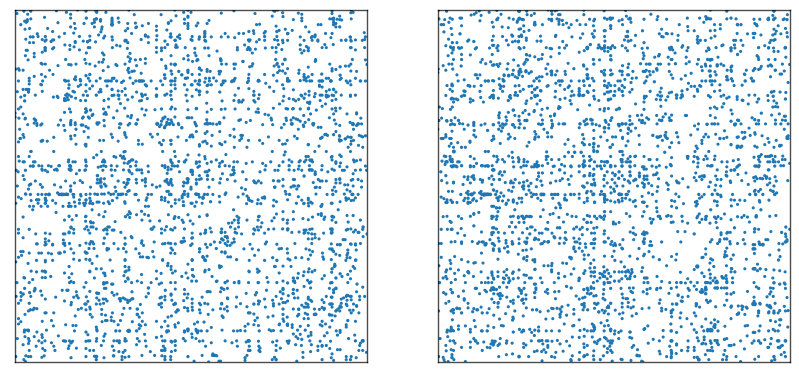

In [12]:
import seaborn as sns
from graspologic.plot import adjplot

fig, axs = plt.subplots(1,2,figsize=(10, 5))
adjplot(np_left_adj[ind_left_list[0]][:, ind_left_list[0]], plot_type='scattermap', ax=axs[0])
adjplot(np_right_adj[ind_right_list[0]][:, ind_right_list[0]], plot_type='scattermap', ax=axs[1])

Permute the skids based on graph matching, this gives us the pairs from graph matching

In [13]:
matched_pairs_list = []

for i in range(n_iters):
    left_matched_skids = left_skids[ind_left_list[i]]
    right_matched_skids = right_skids[ind_right_list[i]]

    #make dataframe for the matched pairs
    matched_pairs = pd.DataFrame(list(zip(left_matched_skids, right_matched_skids)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    matched_pairs_list.append(matched_pairs)

Calculating the accuracy of how graph matching did (compare our pairs to Nadine's pairs)

In [14]:
accuracy_list = []
df_list = []
for i in range(n_iters):
    #merge the true pairs and our matched pairs by their union
    df = pd.merge(true_pairs, matched_pairs_list[i], on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')
    df_list.append(df)
    #the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
    num = df["Exist"].value_counts()["both"]

    #to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
    duplicate_L = df[df.duplicated("skid-ID LEFT")]
    duplicate_R = df[df.duplicated("skid-ID RIGHT")]

    #take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
    #repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
    duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

    #the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
    den = len(duplicate_df) + num
    accuracy = num/den
    accuracy_list.append(accuracy)
    #print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

In [15]:
df1 = pd.DataFrame({'L': [1, 2, 3, 4, 5, 6, 7, 8], 'R': ["a", "b", "c", "d", "e", "f", "g", "h"]})
df2 = pd.DataFrame({'L': [1, 3, 12, 9, 10, 11, 2, 4, 6, 5], 'R': ["a", "d", "h", "r", "w", "u", "b", "d", "q", "c"]})
print(df1)
print(df2)

   L  R
0  1  a
1  2  b
2  3  c
3  4  d
4  5  e
5  6  f
6  7  g
7  8  h
    L  R
0   1  a
1   3  d
2  12  h
3   9  r
4  10  w
5  11  u
6   2  b
7   4  d
8   6  q
9   5  c


In [16]:
new_df = pd.merge(df1, df2, on=["L", 'R'], how="outer", indicator="exist")
test_num = new_df["exist"].value_counts()["both"]
duplicate_L = new_df[new_df.duplicated(['L'])]
duplicate_R = new_df[new_df.duplicated(['R'])]
new_df

,L,R,exist
0,1,a,both
1,2,b,both
2,3,c,left_only
3,4,d,both
4,5,e,left_only
5,6,f,left_only
6,7,g,left_only
7,8,h,left_only
8,3,d,right_only
9,12,h,right_only


In [17]:
print(duplicate_L)
print(duplicate_R)
duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["L", "R"], how="outer", indicator="Exist")
acc = test_num / (test_num + len(duplicate_df))
print(acc)
duplicate_df

    L  R       exist
8   3  d  right_only
13  6  q  right_only
14  5  c  right_only
     L  R       exist
8    3  d  right_only
9   12  h  right_only
14   5  c  right_only
0.42857142857142855


,L,R,exist_x,exist_y,Exist
0,3,d,right_only,right_only,both
1,6,q,right_only,NaN,left_only
2,5,c,right_only,right_only,both
3,12,h,NaN,right_only,right_only


Calculate the norm of the difference of the two adjacencies after permuting the skids

In [18]:
diff_matched_norm_list = []
for i in range(n_iters):
    #norms of matched adjs
    #subset and permute the adjacencies by their indices from matching
    np_left_adj_matched = np_left_adj[np.ix_(ind_left_list[i], ind_left_list[i])]
    np_right_adj_matched = np_right_adj[np.ix_(ind_right_list[i], ind_right_list[i])]

    #calculate norm of difference of matched adjacencies
    np_diff_adj_matched = np_left_adj_matched - np_right_adj_matched
    diff_matched_norm = np.linalg.norm(np_diff_adj_matched)
    diff_matched_norm_list.append(diff_matched_norm)
    #print(f"Norm of difference of left and right matched adjs: {diff_matched_norm}")

In [19]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_whole = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_left_adj), size=len(np_right_adj), replace=False)
    np_left_adj_rand = np_left_adj[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_right_adj), size=len(np_right_adj), replace=False)
    np_right_adj_rand = np_right_adj[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_diff_adj_rand = np_left_adj_rand - np_right_adj_rand
    diff_rand_norm = np.linalg.norm(np_diff_adj_rand)
    rand_norms_whole.append(diff_rand_norm)


In [20]:
accuracy_mean = np.average(accuracy_list)
norm_mean = np.average(diff_matched_norm_list)

Plot histogram showing how our norm compares to the norms after random permutations of the matrices

Text(0.5, 1.0, 'Norm of difference of matched vs random whole adjacencies (norm: 158.71), (accuracy: 0.01)')

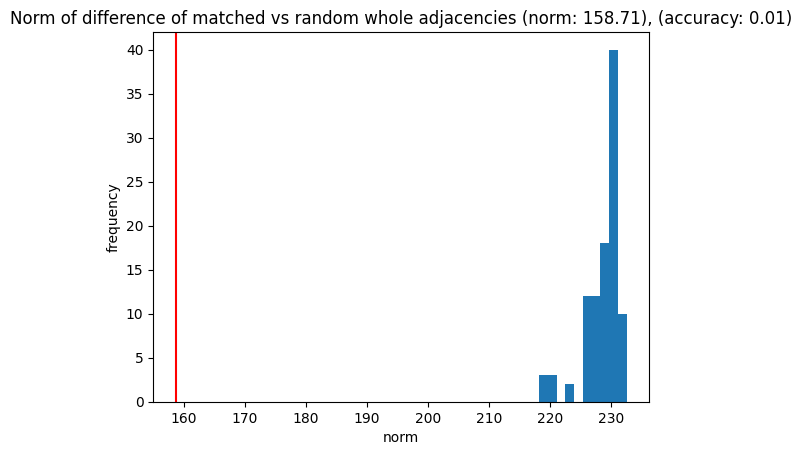

In [21]:
#histogram
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_whole)
ax.axvline(norm_mean, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of matched vs random whole adjacencies (norm: {:.2f}), (accuracy: {:.2f})".format(norm_mean, accuracy_mean))

Look at morphologies of neurons that were paired correctly, 5 morphologies of neurons that were paired correctly in only Nadine's, and 5 morphologies of neurons that were paired in ours

In [22]:
rm = pymaid.CatmaidInstance(
    server="https://catmaid.jekelylab.ex.ac.uk/#",
    project_id=11,
    api_token=None,
    http_user=None,
    http_password=None,
)
logging.getLogger("pymaid").setLevel(logging.WARNING)
pymaid.clear_cache()

INFO  : Global CATMAID instance set. Caching is ON. (pymaid)


In [23]:
#look at correct morphologies
import navis

#make list of CatmaidNeuronList for each pair of neurons
neuron_list_both = []
neuron_list_nadine = []
neuron_list_ours = []

for ind, row in df.iterrows():
    neurons = [row["skid-ID LEFT"], row["skid-ID RIGHT"]]

    #when the pair exists in both our list and Nadine's list
    if(row["Exist"] == "both"):
        neuron_list_both.append([pymaid.get_neuron(neurons), neurons[0], neurons[1]])
    
    #when the pair exists in Nadine's list only
    elif(row["Exist"] == "left_only" and len(neuron_list_nadine)<=5):
        neuron_list_nadine.append([pymaid.get_neuron(neurons), neurons[0], neurons[1]])
    
    #when the pair exists in our list only
    elif(row["Exist"] == "right_only" and len(neuron_list_ours)<=5):
        neuron_list_ours.append([pymaid.get_neuron(neurons), neurons[0], neurons[1]])

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

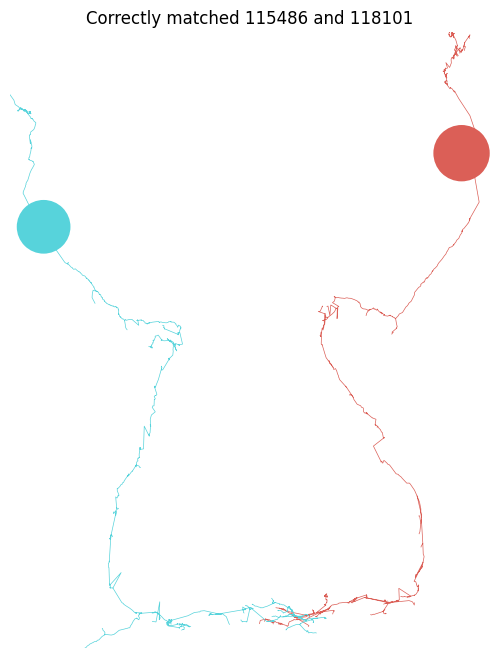

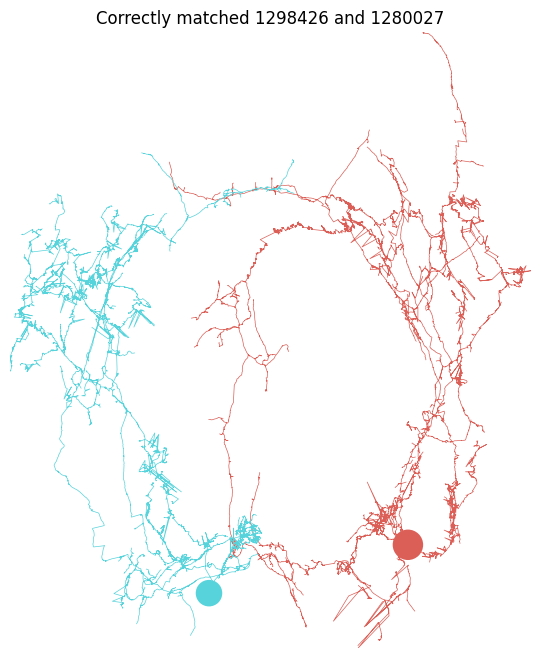

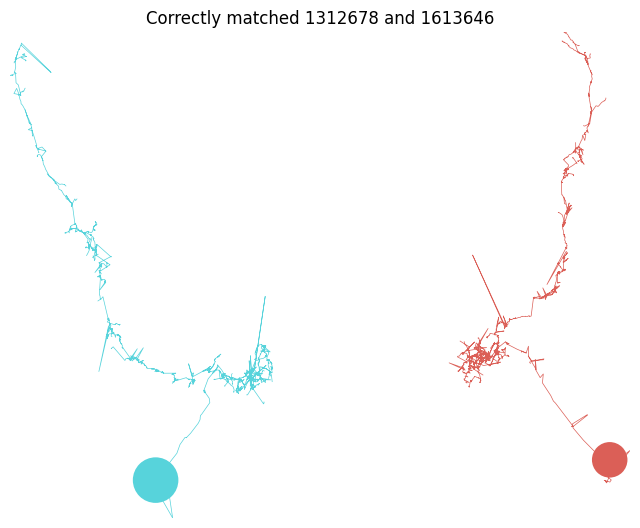

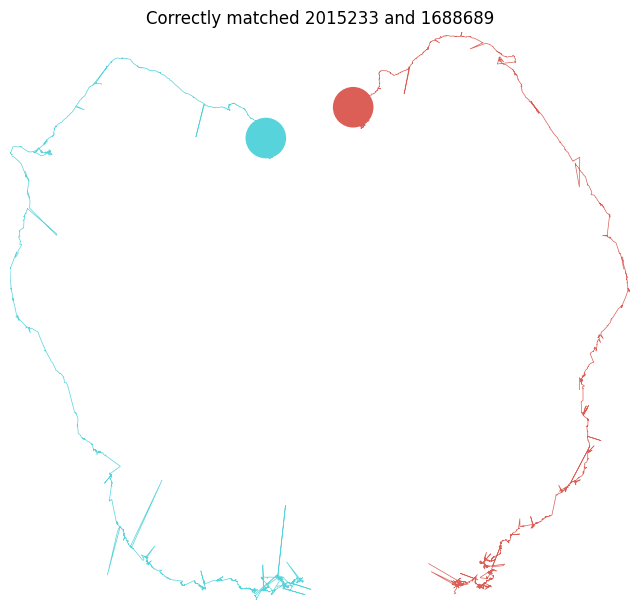

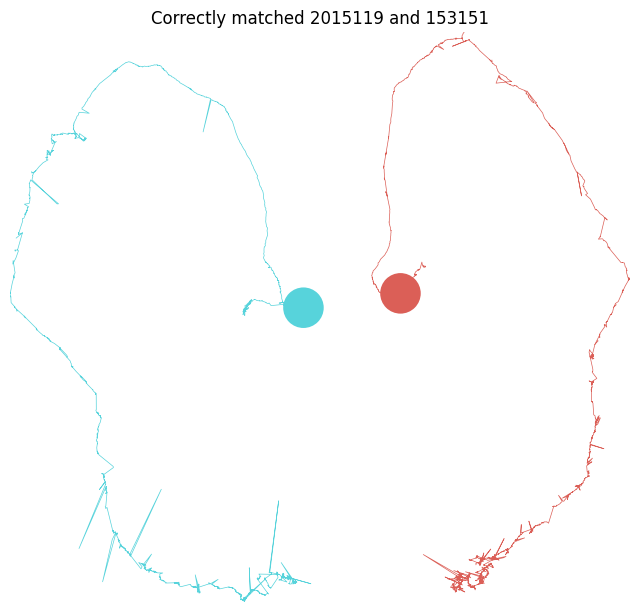

In [24]:
#visualize correctly matched neurons
for i in range(len(neuron_list_both)):
    fig, ax = navis.plot2d(neuron_list_both[i][0], method='2d', view=('x', '-y'))
    left = neuron_list_both[i][1]
    right = neuron_list_both[i][2]
    ax.set_title(f"Correctly matched {left} and {right}")

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

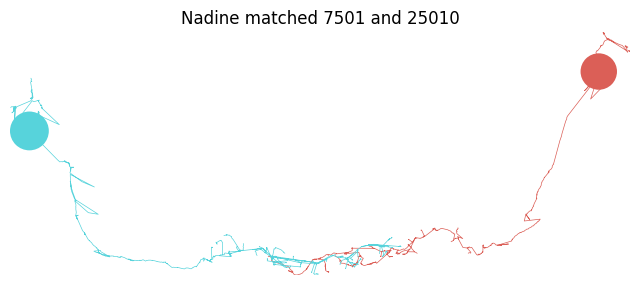

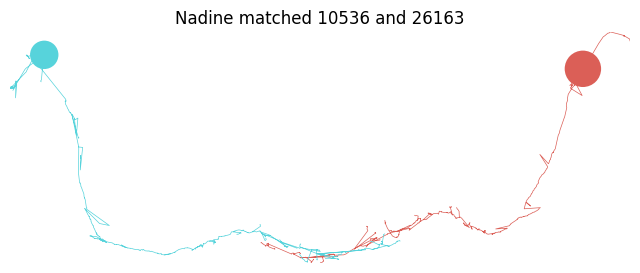

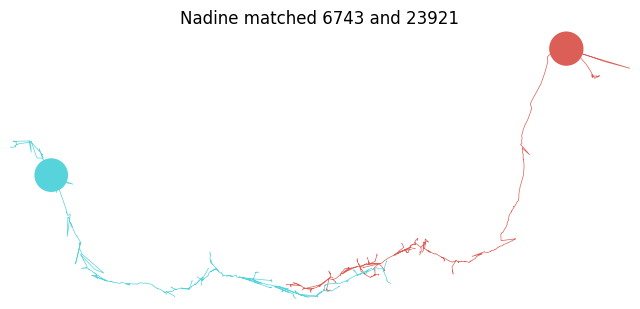

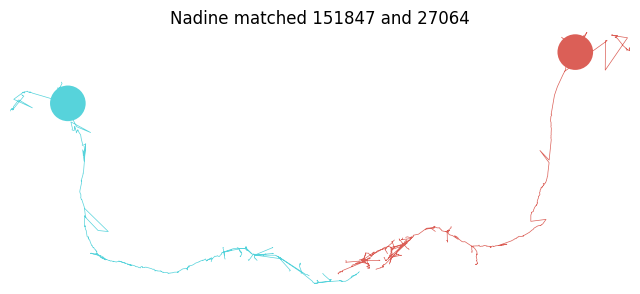

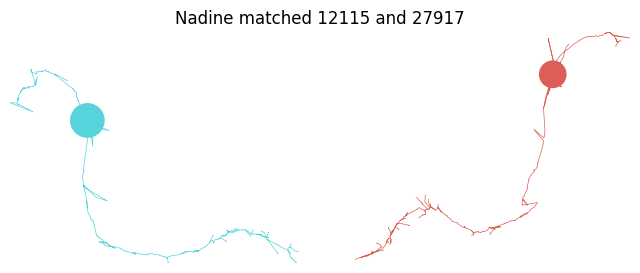

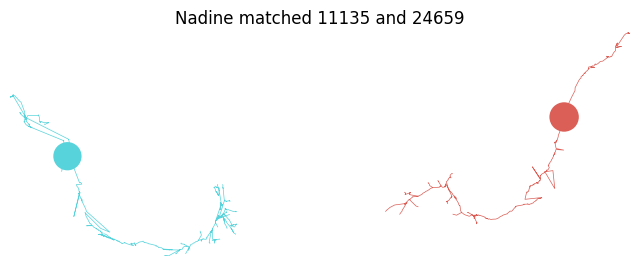

In [25]:
#visualize neurons that nadines matched that was not in ours
for i in range(len(neuron_list_nadine)):
    fig, ax = navis.plot2d(neuron_list_nadine[i][0], method='2d', view=('x', '-y'))
    left = neuron_list_nadine[i][1]
    right = neuron_list_nadine[i][2]
    ax.set_title(f"Nadine matched {left} and {right}")

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

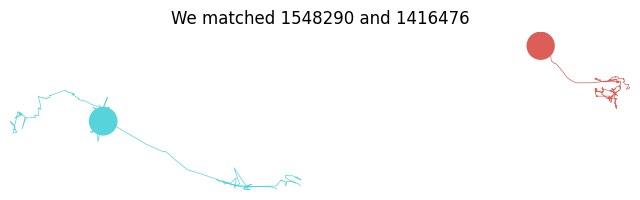

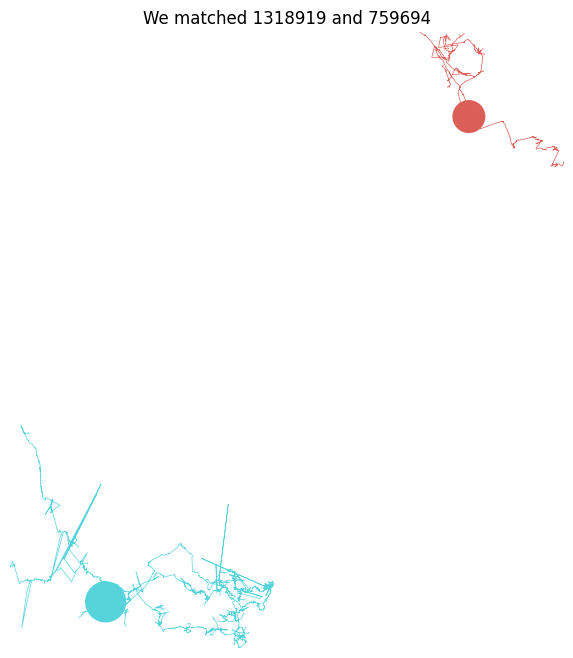

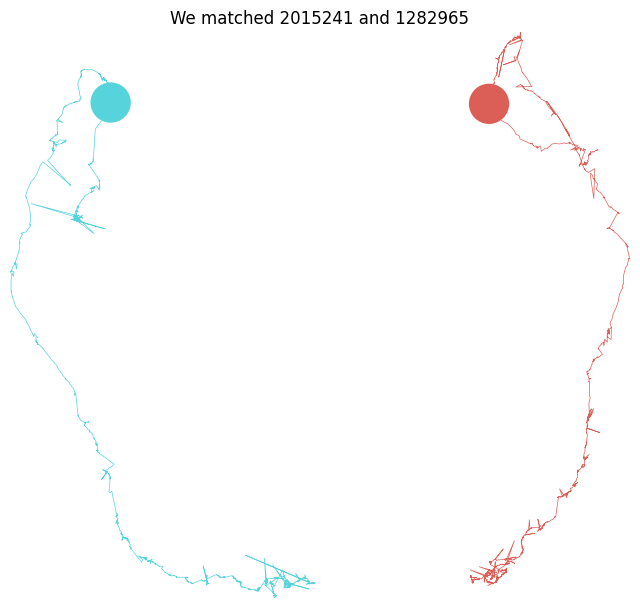

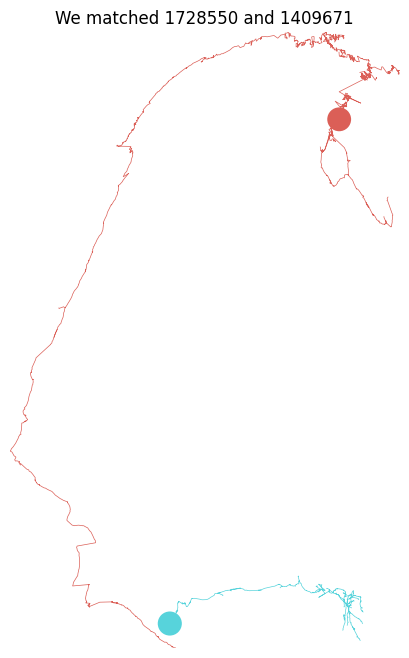

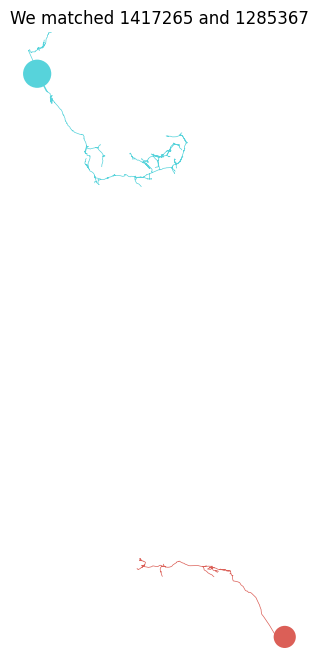

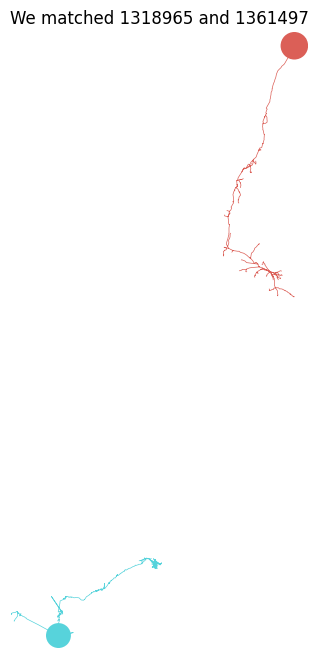

In [26]:
#visualize neurons that we matched that nadine did not
for i in range(len(neuron_list_ours)):
    fig, ax = navis.plot2d(neuron_list_ours[i][0], method='2d', view=('x', '-y'))
    left = neuron_list_ours[i][1]
    right = neuron_list_ours[i][2]
    ax.set_title(f"We matched {left} and {right}")

Look at what happens if we initialize a permutation matrix such that the left and right adjs match Nadine's pairs

In [27]:
#first move all the left skids that are in Nadine's list to the front of the left skids list
left_skids_copy = np.array(left_skids)

#find left indices that correspond to Nadine's list
inds_nadine = [list(np.where(left_skids_copy == j)[0]) for j in left_true]

#modify inds_nadine to get rid of all empty lists (skids that exist in Nadine's skid list but not ours) and make list elements as ints
inds_nadine_filt = [ele[0] for ele in inds_nadine if ele != []]
inds_nadine_filt = np.array(inds_nadine_filt)

#save the elements that correspond (and not) to inds_nadine_filt in left_skids_copy
skids_left_nadine = left_skids_copy[inds_nadine_filt]
skids_left_not_nadine = [skid for skid in left_skids_copy if skid not in skids_left_nadine]
skids_left_not_nadine = np.array(skids_left_not_nadine)

#now concatenate the nadine skids and not_nadine left skids
skids_left_form = np.append(skids_left_nadine, skids_left_not_nadine, axis=0)

#now permute the right index list such that the pairs align with Nadine's
right_skids_copy = np.array(right_skids)

#go through the first entires of left_skids_copy and find the right_skid that corresponds to it in true_pairs
for i in range(len(inds_nadine_filt)):

    #find the index where the current left skid appears in true pairs
    ind_pair = true_pairs.loc[true_pairs["skid-ID LEFT"] == skids_left_form[i]].index[0]

    #find the right skid that corresponds to the left_skid in true pairs
    right_skid = true_pairs.loc[ind_pair, "skid-ID RIGHT"]

    #find where this right_skid is in our right_skids list, if it is not there then continue
    if right_skid not in right_skids_copy:
        continue
    
    else:
        
        #swap right_skid with the skid where it needs to go
        ind_right_curr = np.where(right_skids_copy == right_skid)[0][0]
        temp = right_skids_copy[i]
        right_skids_copy[i] = right_skid
        right_skids_copy[ind_right_curr] = temp
        
skids_right_form = right_skids_copy.copy()
whole_nadine_nadine_pairs = pd.DataFrame(list(zip(skids_left_form, skids_right_form)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])

In [28]:
whole_nadine_nadine_pairs

,skid-ID LEFT,skid-ID RIGHT
0,7501,25010
1,10536,26163
2,6743,23921
3,151847,27064
4,12115,27917
...,...,...
914,1629613,608173
915,1310144,1621996
916,1670599,1441775
917,1424853,1597423


Calculate the accuracy of our permuted left and right skids do (without running graph matchingf)

In [29]:
#Accuracy of WHOLE, NADINE, NADINE

#merge the true pairs and our matched pairs by their union
whole_nadine_df = pd.merge(true_pairs, whole_nadine_nadine_pairs, on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

#the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
num = whole_nadine_df["Exist"].value_counts()["both"]

#to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
duplicate_L = whole_nadine_df[whole_nadine_df.duplicated("skid-ID LEFT")]
duplicate_R = whole_nadine_df[whole_nadine_df.duplicated("skid-ID RIGHT")]

#take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
#repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

#the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
den = len(duplicate_df) + num
accuracy_whole_nadine_nadine = num/den
print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9205776173285198


Calculate the norms of the left and right adjs after permuting the skids (no graph matching)

In [30]:
#norms of whole nadine init adjs

#chop the last skids of the left skid list so the dimensions match
skids_left_form_trunc = skids_left_form[0:len(skids_right_form)]

#make adjs
whole_nadine_left_adj = pymaid.adjacency_matrix(skids_left_form)
whole_nadine_left_adj_trunc = pymaid.adjacency_matrix(skids_left_form_trunc)
whole_nadine_right_adj = pymaid.adjacency_matrix(skids_right_form)

np_whole_nadine_left_adj = np.array(whole_nadine_left_adj)
np_whole_nadine_left_adj_trunc = np.array(whole_nadine_left_adj_trunc)
np_whole_nadine_right_adj = np.array(whole_nadine_right_adj)

#calculate norm of difference of matched adjacencies
np_diff_whole_nadine = np_whole_nadine_left_adj_trunc - np_whole_nadine_right_adj
diff_whole_nadine_norm = np.linalg.norm(np_diff_whole_nadine)

print(f"Norm of difference of left and right matched adjs: {diff_whole_nadine_norm}")

Norm of difference of left and right matched adjs: 204.9024157983502


In [31]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_whole_nadine = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_whole_nadine_left_adj_trunc), size=len(np_whole_nadine_right_adj), replace=False)
    np_whole_nadine_left_adj_rand = np_whole_nadine_left_adj_trunc[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_whole_nadine_right_adj), size=len(np_whole_nadine_right_adj), replace=False)
    np_whole_nadine_right_adj_rand = np_whole_nadine_right_adj[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_whole_nadine_diff_adj_rand = np_whole_nadine_left_adj_rand - np_whole_nadine_right_adj_rand
    diff_whole_nadine_rand_norm = np.linalg.norm(np_whole_nadine_diff_adj_rand)
    rand_norms_whole_nadine.append(diff_whole_nadine_rand_norm)

Text(0.5, 1.0, 'Norm of difference of initialized vs random whole adjacencies (norm: 204.90), (accuracy: 0.92)')

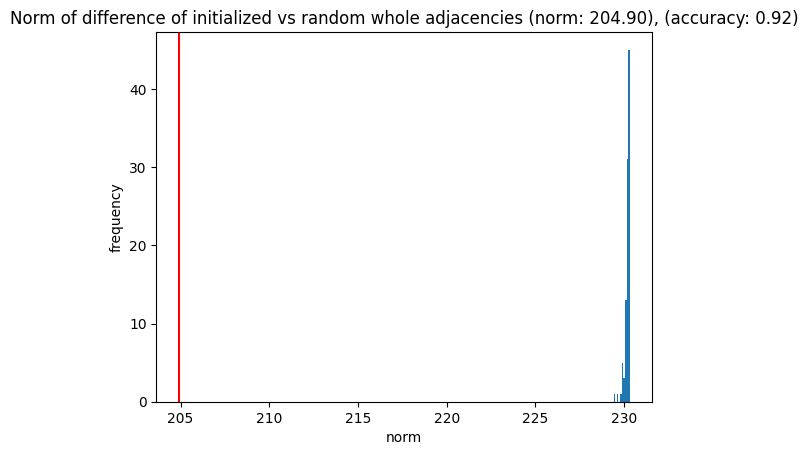

In [32]:
#histogram for WHOLE, NADINE, NADINE
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_whole_nadine)
ax.axvline(diff_whole_nadine_norm, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of initialized vs random whole adjacencies (norm: {:.2f}), (accuracy: {:.2f})".format(diff_whole_nadine_norm, accuracy_whole_nadine_nadine))

Run graph matching on our permuted adjs

In [33]:
whole_nadine_ind_left_list = []
whole_nadine_ind_right_list = []

In [34]:
#WHOLE, NADINE, OPT
for i in range(n_iters):
    whole_nadine_ind_left, whole_nadine_ind_right, score, _ = graph_match(np_whole_nadine_left_adj, np_whole_nadine_right_adj)
    whole_nadine_ind_left_list.append(whole_nadine_ind_left)
    whole_nadine_ind_right_list.append(whole_nadine_ind_right)

In [35]:
#score from WHOLE NADINE OPT
score

14853.0

In [36]:
whole_nadine_matched_pairs_list = []
for i in range(n_iters):
    skids_left_form_matched = skids_left_form[whole_nadine_ind_left_list[i]]
    skids_right_form_matched = skids_right_form[whole_nadine_ind_right_list[i]]

    #make dataframe for the matched pairs
    whole_nadine_matched_pairs = pd.DataFrame(list(zip(skids_left_form_matched, skids_right_form_matched)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    whole_nadine_matched_pairs_list.append(whole_nadine_matched_pairs)

Calculate the accuracy after running graph matching on our permuted adjs

In [37]:
#WHOLE, NADINE, OPT
whole_nadine_matched_accuracy_list = []
for i in range(n_iters):
    #merge the true pairs and our matched pairs by their union
    whole_nadine_matched_df = pd.merge(true_pairs, whole_nadine_matched_pairs_list[i], on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

    #the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
    num = whole_nadine_matched_df["Exist"].value_counts()["both"]

    #to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
    duplicate_L = whole_nadine_matched_df[whole_nadine_matched_df.duplicated("skid-ID LEFT")]
    duplicate_R = whole_nadine_matched_df[whole_nadine_matched_df.duplicated("skid-ID RIGHT")]

    #take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
    #repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
    duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

    #the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
    den = len(duplicate_df) + num
    accuracy = num/den
    whole_nadine_matched_accuracy_list.append(accuracy)
    #print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

Calculate norm from running graph matching on our permuted adjs

In [38]:
#norms of whole nadine init opt adjs
whole_nadine_matched_norm_list = []
for i in range(n_iters):
    #subset and permute the adjacencies by their indices from matching
    np_whole_nadine_matched_left_adj = np_whole_nadine_left_adj[np.ix_(whole_nadine_ind_left_list[i], whole_nadine_ind_left_list[i])]
    np_whole_nadine_matched_right_adj = np_whole_nadine_right_adj[np.ix_(whole_nadine_ind_right_list[i], whole_nadine_ind_right_list[i])]

    #calculate norm of difference of matched adjacencies
    np_whole_nadine_matched_diff = np_whole_nadine_matched_left_adj - np_whole_nadine_matched_right_adj
    diff_whole_nadine_matched_norm = np.linalg.norm(np_whole_nadine_matched_diff)
    whole_nadine_matched_norm_list.append(diff_whole_nadine_matched_norm)
    #print(f"Norm of difference of left and right matched adjs: {diff_whole_nadine_matched_norm}")

In [39]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_whole_nadine = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_whole_nadine_left_adj), size=len(np_whole_nadine_right_adj), replace=False)
    np_whole_nadine_left_adj_rand = np_whole_nadine_left_adj[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_whole_nadine_right_adj), size=len(np_whole_nadine_right_adj), replace=False)
    np_whole_nadine_right_adj_rand = np_whole_nadine_right_adj[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_whole_nadine_diff_adj_rand = np_whole_nadine_left_adj_rand - np_whole_nadine_right_adj_rand
    diff_whole_nadine_rand_norm = np.linalg.norm(np_whole_nadine_diff_adj_rand)
    rand_norms_whole_nadine.append(diff_whole_nadine_rand_norm)

In [40]:
whole_nadine_matched_norm_average = np.average(whole_nadine_matched_norm_list)
whole_nadine_matched_accuracy_average = np.average(whole_nadine_matched_accuracy_list)

Text(0.5, 1.0, 'Norm of difference of initialized matched vs random whole adjacencies (norm: 158.49), (accuracy: 0.01)')

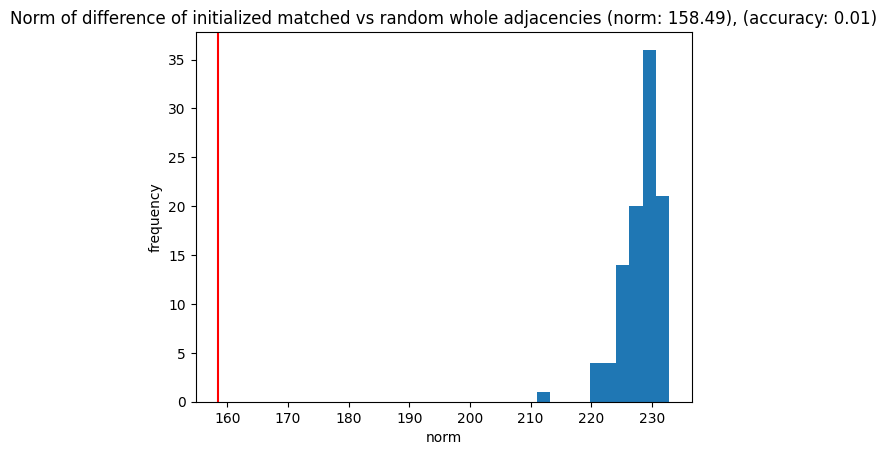

In [41]:
#histogram of WHOLE NADINE OPT
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_whole_nadine)
ax.axvline(whole_nadine_matched_norm_average, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of initialized matched vs random whole adjacencies (norm: {:.2f}), (accuracy: {:.2f})".format(whole_nadine_matched_norm_average, whole_nadine_matched_accuracy_average))

Do all the same analyses, but run on the subgraph (from our total list of left and right neurons, use the subsets of the neurons that exist in true pairs)

In [42]:
sub_left_skids = [skid for skid in left_skids if skid in left_true]
sub_right_skids = [skid for skid in right_skids if skid in right_true]

pd_sub_left_skids = pd.Series(sub_left_skids)
pd_sub_right_skids = pd.Series(sub_right_skids)

print(len(sub_left_skids))
print(len(sub_right_skids))

272
260


In [44]:
#get the sub labels for class similarity purposes

#find the inds from left and right skid lists that are in the respective subgraphs
left_inds = [i for i, e in enumerate(left_skids) if e in sub_left_skids]
right_inds = [i for i, e in enumerate(right_skids) if e in sub_right_skids]

#np_left_labels = np.array(left_labels)
#np_right_labels = np.array(right_labels)

#grab the subset of labels from the ind lists
sub_left_labels = np_left_labels[left_inds]
sub_right_labels = np_left_labels[right_inds]

In [48]:
sub_left_adj = pymaid.adjacency_matrix(sub_left_skids)
sub_right_adj = pymaid.adjacency_matrix(sub_right_skids)

np_sub_left_adj = np.array(sub_left_adj)
np_sub_right_adj = np.array(sub_right_adj)

In [49]:
sub_ind_left_list = []
sub_ind_right_list = []

Run graph matching without any initialization

In [50]:
#SUB, DEFAULT, OPT
for i in range(n_iters):
    sub_ind_left, sub_ind_right, sub_score, sub_misc = graph_match(np_sub_left_adj, np_sub_right_adj)
    sub_ind_left_list.append(sub_ind_left)
    sub_ind_right_list.append(sub_ind_right)

In [51]:
#Score from SUB, DEFAULT, OPT
sub_score

5248.0

Permute our lists of skids based on the results of graph matching

In [52]:
sub_matched_pairs_list = []
for i in range(n_iters):
    sub_left_matched_skids = pd_sub_left_skids[sub_ind_left_list[i]]
    sub_right_matched_skids = pd_sub_right_skids[sub_ind_right_list[i]]

    #make dataframe for the matched pairs
    sub_matched_pairs = pd.DataFrame(list(zip(sub_left_matched_skids, sub_right_matched_skids)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    sub_matched_pairs_list.append(sub_matched_pairs)

Calculate the accuracy on our subgraphs after graph matching without initialization

In [53]:
sub_matched_accuracy_list = []
for i in range(n_iters):
    #merge the true pairs and our matched pairs by their union
    sub_df = pd.merge(true_pairs, sub_matched_pairs_list[i], on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

    #the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
    sub_num = sub_df["Exist"].value_counts()["both"]

    #to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
    duplicate_L = sub_df[sub_df.duplicated("skid-ID LEFT")]
    duplicate_R = sub_df[sub_df.duplicated("skid-ID RIGHT")]

    #take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
    #repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
    duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

    #the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
    sub_den = len(duplicate_df) + sub_num
    accuracy = sub_num/sub_den
    sub_matched_accuracy_list.append(accuracy)

    #print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(sub_num/sub_den))

Collect the neurons that were correctly matched from graph matching

In [54]:
correct_sub_df = sub_df.loc[sub_df["Exist"] == "both"]
correct_sub_df = correct_sub_df.reset_index()
correct_sub_df

,level_0,index,skid-ID LEFT,skid-ID RIGHT,Exist
0,21,21.0,252853,252137,both
1,49,69.0,1075718,1077309,both
2,77,160.0,386671,161743,both
3,78,161.0,1298426,1280027,both
4,84,168.0,1295517,715837,both
5,93,203.0,1391222,1387435,both
6,95,205.0,1729648,1307524,both
7,98,219.0,2008640,1837982,both
8,100,221.0,1850496,1845760,both
9,106,227.0,1678918,369396,both


Visualize the correctly matched neurons

In [55]:
import navis

#make list of CatmaidNeuronList for each pair of neurons
neuron_list = []
for ind, row in correct_sub_df.iterrows():
    neurons = [row["skid-ID LEFT"], row["skid-ID RIGHT"]]
    neuron_list.append(pymaid.get_neuron(neurons))

neuron_list

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

[<class 'pymaid.core.CatmaidNeuronList'> containing 2 neurons (145.0KiB)
             type     name skeleton_id  n_nodes  n_connectors  n_branches  \
 0  CatmaidNeuron  cPRC_l2      252853     2524            88         137   
 1  CatmaidNeuron  cPRC_r2      252137     1969            74          93   
 
    n_leafs  cable_length      soma        units  
 0      164  521405.15625  [252901]  1 nanometer  
 1       97  322183.46875  [248997]  1 nanometer  ,
 <class 'pymaid.core.CatmaidNeuronList'> containing 2 neurons (98.0KiB)
             type                    name skeleton_id  n_nodes  n_connectors  \
 0  CatmaidNeuron  SNPDF-dc_l1_DLSO1.1_4l     1075718     1420            16   
 1  CatmaidNeuron  SNPDF-dc_r1_DLSO1.1_4r     1077309     1681            17   
 
    n_branches  n_leafs  cable_length       soma        units  
 0          59       62   283754.3125  [1089674]  1 nanometer  
 1          71       79   341822.4375  [1078803]  1 nanometer  ,
 <class 'pymaid.core.CatmaidNeuro

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

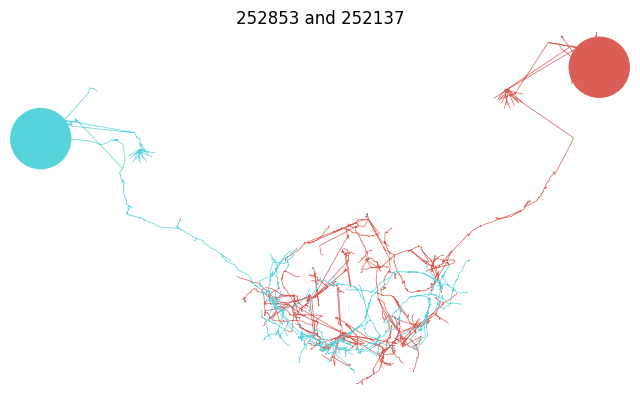

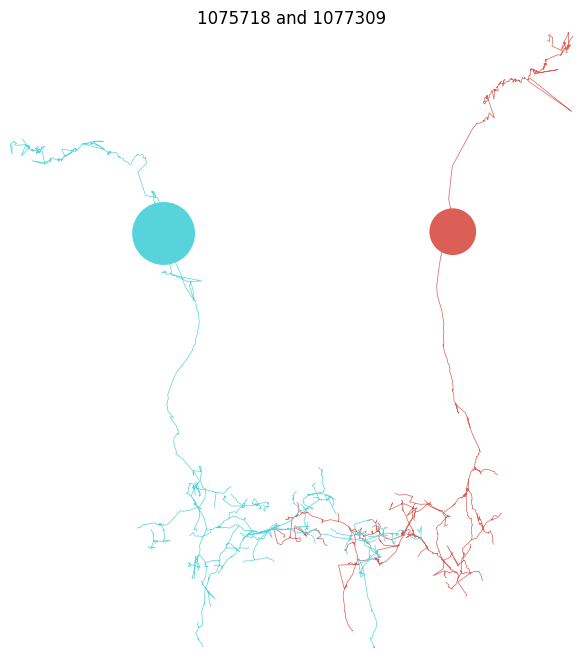

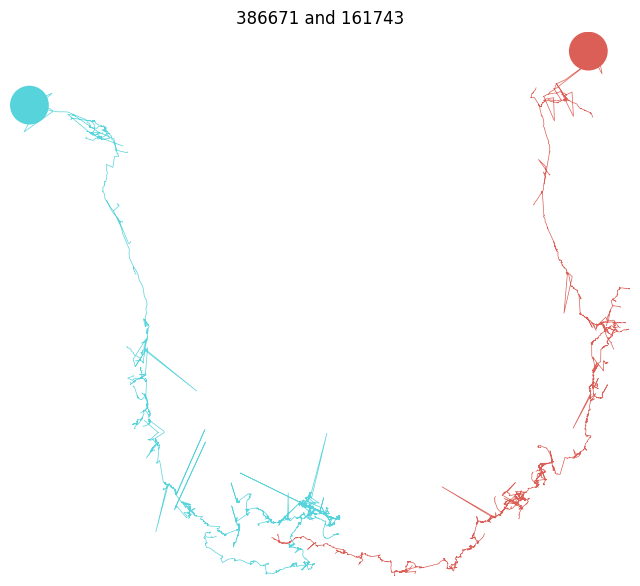

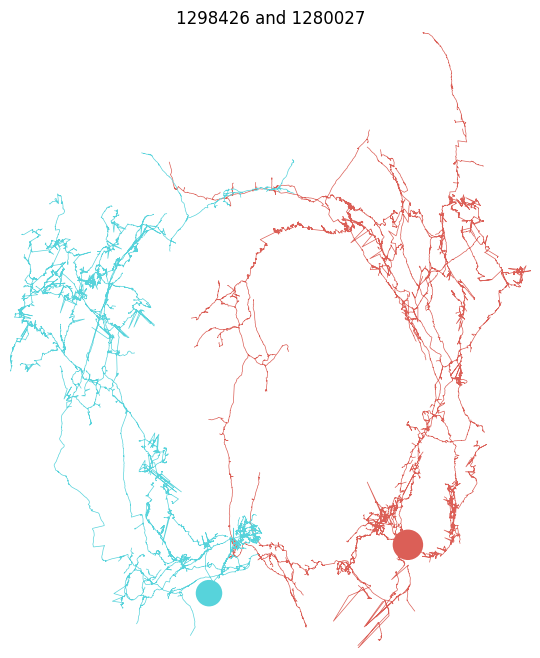

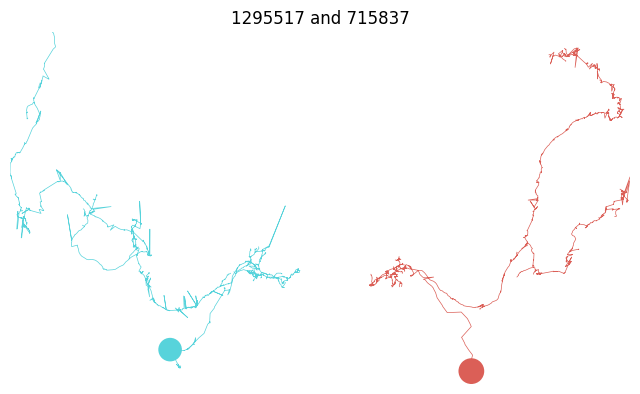

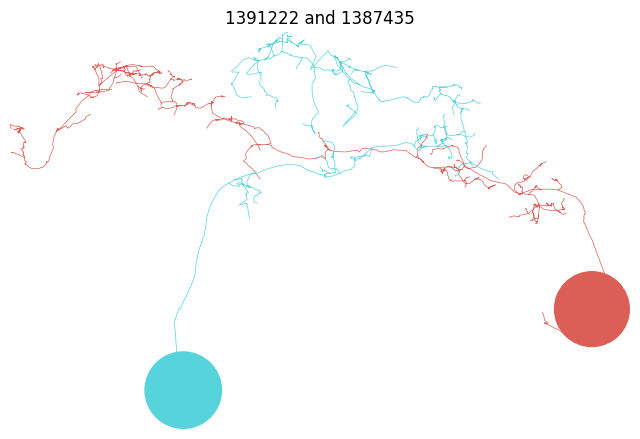

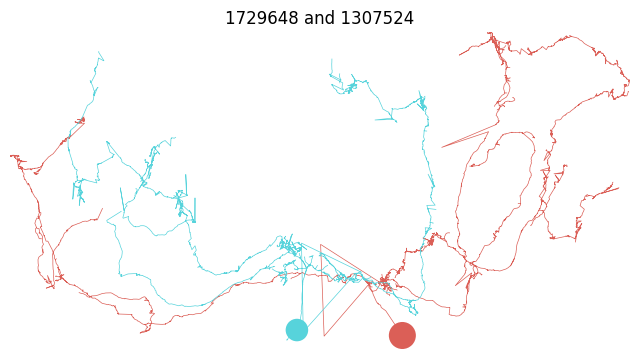

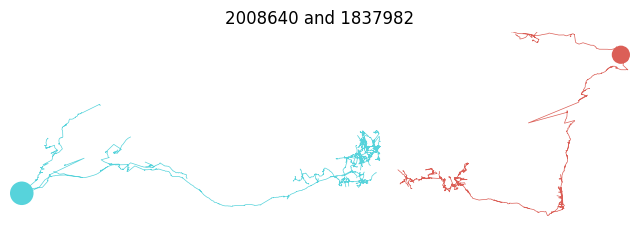

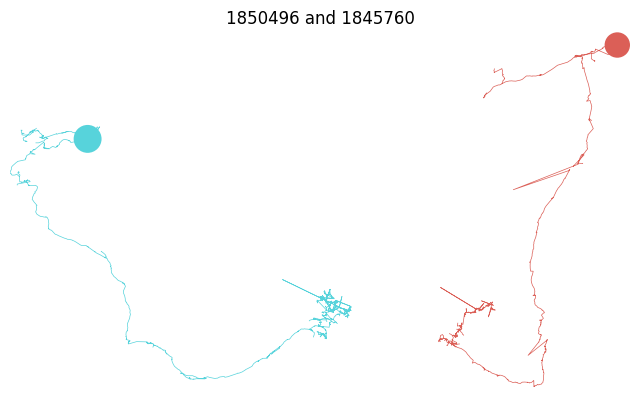

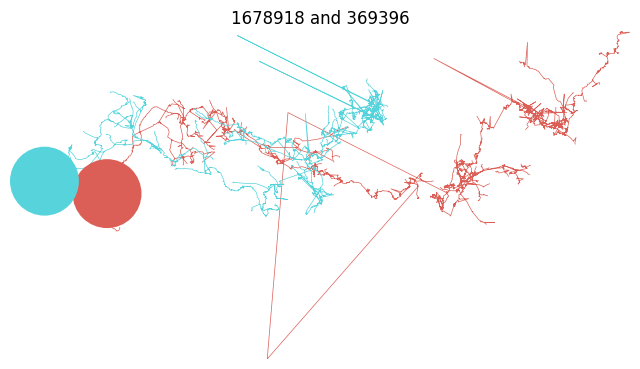

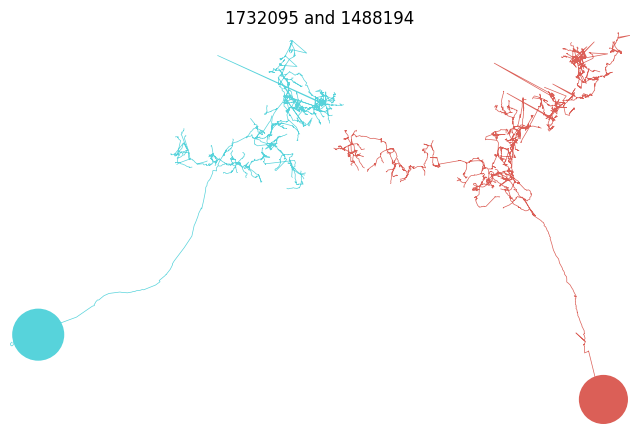

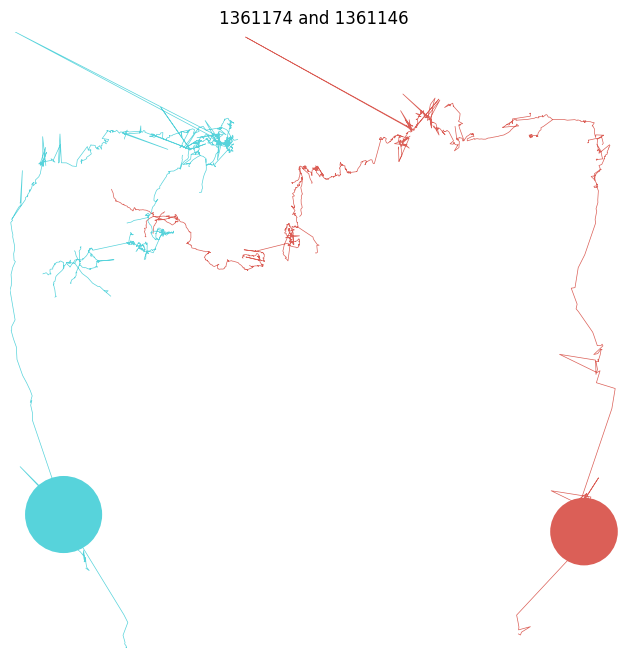

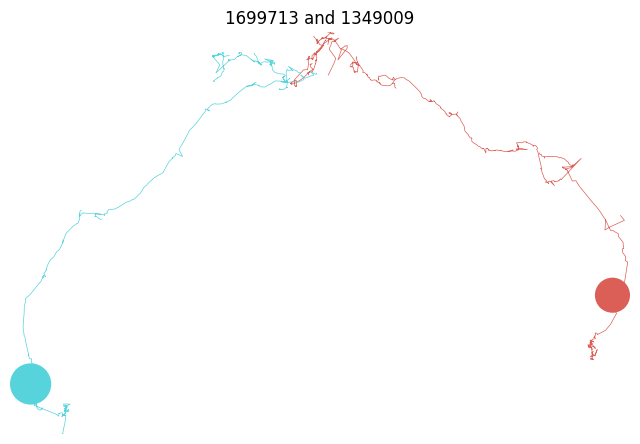

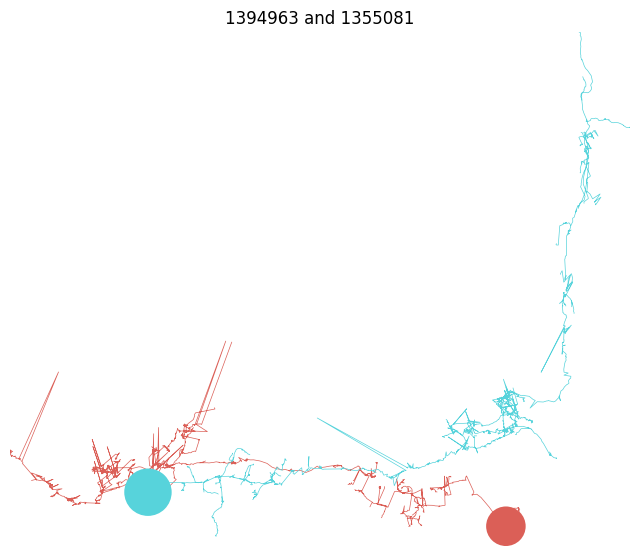

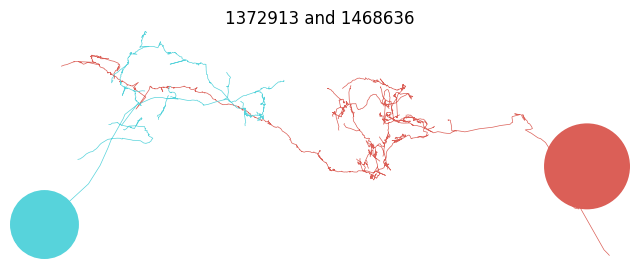

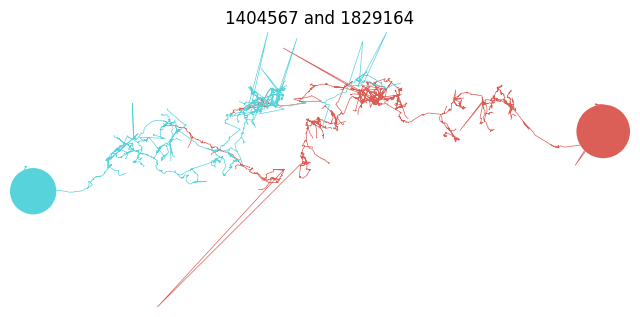

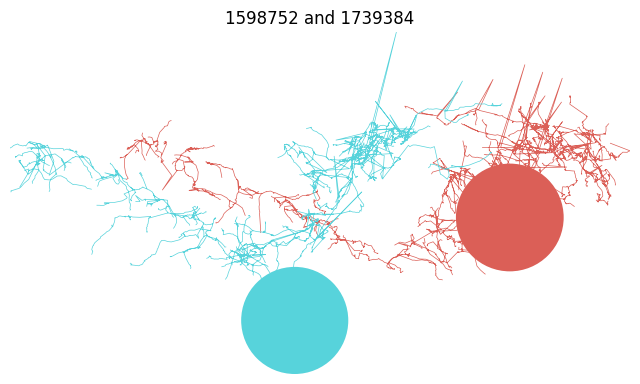

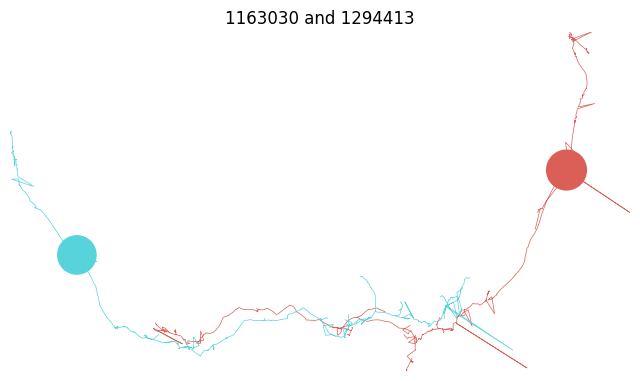

In [56]:
for i in range(len(neuron_list)):
    fig, ax = navis.plot2d(neuron_list[i], method='2d', view=('x', '-y'))
    left = correct_sub_df.loc[i, "skid-ID LEFT"]
    right = correct_sub_df.loc[i, "skid-ID RIGHT"]
    ax.set_title(f"{left} and {right}")

Take the norm of our subgraphs from graph matching

In [57]:
#norms of matched adjs
#subset and permute the adjacencies by their indices from matching
sub_matched_norm_list = []
for i in range(n_iters):
    np_sub_left_adj_matched = np_sub_left_adj[np.ix_(sub_ind_left_list[i], sub_ind_left_list[i])]
    np_sub_right_adj_matched = np_sub_right_adj[np.ix_(sub_ind_right_list[i], sub_ind_right_list[i])]

    #calculate norm of difference of matched adjacencies
    np_sub_diff_adj_matched = np_sub_left_adj_matched - np_sub_right_adj_matched
    sub_diff_matched_norm = np.linalg.norm(np_sub_diff_adj_matched)
    sub_matched_norm_list.append(sub_diff_matched_norm)
    #print(f"Norm of difference of left and right matched adjs: {sub_diff_matched_norm}")

In [58]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_sub_left_adj), size=len(np_sub_right_adj), replace=False)
    np_sub_left_adj_rand = np_sub_left_adj[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_sub_right_adj), size=len(np_sub_right_adj), replace=False)
    np_sub_right_adj_rand = np_sub_right_adj[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_sub_diff_adj_rand = np_sub_left_adj_rand - np_sub_right_adj_rand
    sub_diff_rand_norm = np.linalg.norm(np_sub_diff_adj_rand)
    rand_norms.append(sub_diff_rand_norm)

#print(f"Norm of difference of left and right randomly permuted adjs: {sub_diff_rand_norm}")

In [59]:
sub_matched_norm_average = np.average(sub_matched_norm_list)
sub_matched_accuracy_average = np.average(sub_matched_accuracy_list)

Text(0.5, 1.0, 'Norm of difference of matched vs random sub adjacencies (norm: 77.15), (accuracy: 0.06)')

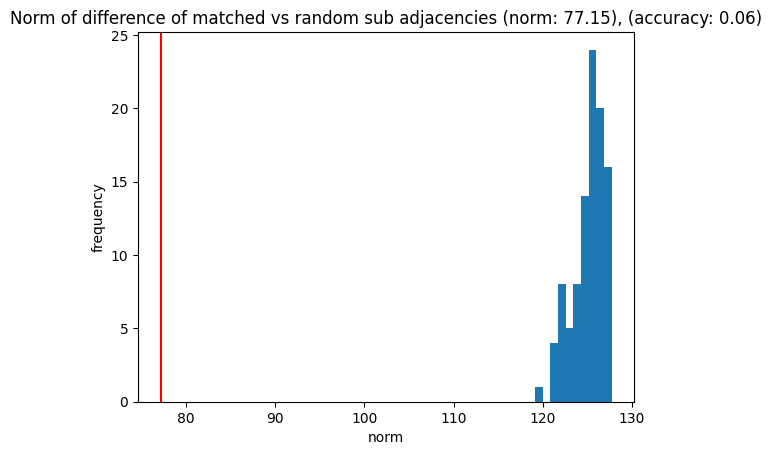

In [60]:
#histogram
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms)
ax.axvline(sub_matched_norm_average, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of matched vs random sub adjacencies (norm: {:.2f}), (accuracy: {:.2f})".format(sub_matched_norm_average, sub_matched_accuracy_average))

Look at what happens if we initialize a permutation matrix such that the left and right adjs match Nadine's pairs

In [61]:
#first move all the right skids that are in Nadine's list to the front of the right skids list
#note: doing right skids instead of left skids first because will go out of bounds when starting with left skids
sub_right_skids_copy = np.array(sub_right_skids)

#find right indices that correspond to Nadine's list
sub_inds_nadine = [list(np.where(sub_right_skids_copy == j)[0]) for j in right_true]

#modify inds_nadine to get rid of all empty lists and make list elements as ints
sub_inds_nadine_filt = [ele[0] for ele in sub_inds_nadine if ele != []]
sub_inds_nadine_filt = np.array(sub_inds_nadine_filt)

#save the elements that correspond (and not) to inds_nadine_filt in sub_right_skids_copy
sub_skids_right_nadine = sub_right_skids_copy[sub_inds_nadine_filt]
sub_skids_right_not_nadine = [skid for skid in sub_right_skids_copy if skid not in sub_skids_right_nadine]
sub_skids_right_not_nadine = np.array(sub_skids_right_not_nadine)

#now concatenate the nadine skids and not_nadine right skids
sub_skids_right_form = np.append(sub_skids_right_nadine, sub_skids_right_not_nadine, axis=0)

#now permute the left index list such that the pairs align with Nadine's
sub_left_skids_copy = np.array(sub_left_skids)

#go through the first entries of right_skids_copy and find the left_skid that corresponds to it in true_pairs
for i in range(len(sub_inds_nadine_filt)):
    
    #get the left skid which exists in nadine's pairs
    right_skid = sub_skids_right_form[i]

    #find the left skid that corresponds to the left_skid in true_pair
    sub_ind_pair = true_pairs.loc[true_pairs["skid-ID RIGHT"] == sub_skids_right_form[i]].index[0]
    left_skid = true_pairs.loc[sub_ind_pair, "skid-ID LEFT"]

    #find where this left_skid is in the left_skids list, if it is not there then continue
    if left_skid not in sub_left_skids_copy:
        continue
    
    else:
        #swap left_skid with the skid where it needs to go
        ind_left_curr = np.where(sub_left_skids_copy == left_skid)[0][0]
        temp = sub_left_skids_copy[i]
        sub_left_skids_copy[i] = left_skid
        sub_left_skids_copy[ind_left_curr] = temp
        
sub_skids_left_form = sub_left_skids_copy.copy()
sub_nadine_nadine_pairs = pd.DataFrame(list(zip(sub_skids_left_form, sub_skids_right_form)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])

Calculate the accuracy on our subgraphs after initialization without graph matching

In [62]:
#Accuracy for SUB, NADINE, NADINE

#merge the true pairs and our matched pairs by their union
sub_nadine_df = pd.merge(true_pairs, sub_nadine_nadine_pairs, on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

#the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
num = sub_nadine_df["Exist"].value_counts()["both"]

#to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
duplicate_L = sub_nadine_df[sub_nadine_df.duplicated("skid-ID LEFT")]
duplicate_R = sub_nadine_df[sub_nadine_df.duplicated("skid-ID RIGHT")]

#take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
#repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

#the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
den = len(duplicate_df) + num
diff_sub_nadine_accuracy = num/den
print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))


The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9807692307692307


Calculate the norm of our subgraphs after initialization without graph matching

In [63]:
#norms of whole nadine init adjs

#chop the last skids of the left skid list so the dimensions match
sub_skids_left_form_trunc = sub_skids_left_form[0:len(sub_skids_right_form)]

#make adjs
sub_nadine_left_adj = pymaid.adjacency_matrix(sub_skids_left_form)
sub_nadine_left_adj_trunc = pymaid.adjacency_matrix(sub_skids_left_form_trunc)
sub_nadine_right_adj = pymaid.adjacency_matrix(sub_skids_right_form)

np_sub_nadine_left_adj = np.array(sub_nadine_left_adj)
np_sub_nadine_left_adj_trunc = np.array(sub_nadine_left_adj_trunc)
np_sub_nadine_right_adj = np.array(sub_nadine_right_adj)

#calculate norm of difference of matched adjacencies
np_diff_sub_nadine = np_sub_nadine_left_adj_trunc - np_sub_nadine_right_adj
diff_sub_nadine_norm = np.linalg.norm(np_diff_sub_nadine)

print(f"Norm of difference of left and right subgraph Nadine initialized adjs: {diff_sub_nadine_norm}")

Norm of difference of left and right subgraph Nadine initialized adjs: 77.0454411370329


In [64]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_sub_nadine = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_sub_nadine_left_adj_trunc), size=len(np_sub_nadine_right_adj), replace=False)
    np_sub_nadine_left_adj_rand = np_sub_nadine_left_adj_trunc[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_sub_nadine_right_adj), size=len(np_sub_nadine_right_adj), replace=False)
    np_sub_nadine_right_adj_rand = np_sub_nadine_right_adj[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_sub_nadine_diff_adj_rand = np_sub_nadine_left_adj_rand - np_sub_nadine_right_adj_rand
    diff_sub_nadine_rand_norm = np.linalg.norm(np_sub_nadine_diff_adj_rand)
    rand_norms_sub_nadine.append(diff_sub_nadine_rand_norm)

Text(0.5, 1.0, 'Norm of difference of initialized vs random sub adjacencies (norm: 77.05), (accuracy: 0.98)')

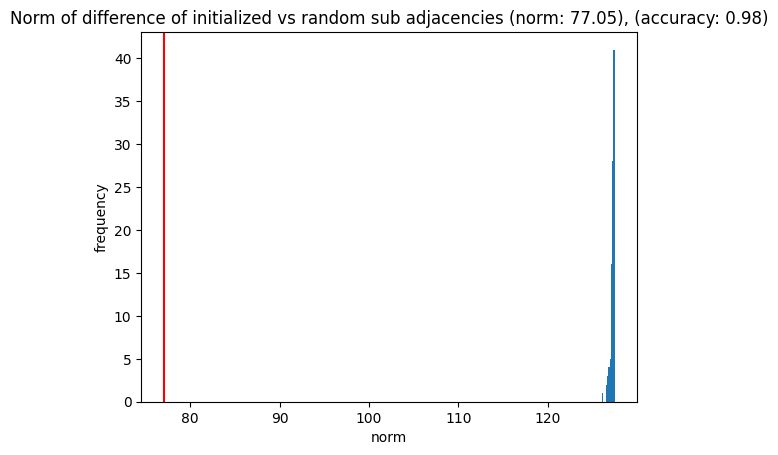

In [65]:
#histogram for WHOLE, NADINE, NADINE
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_sub_nadine)
ax.axvline(diff_sub_nadine_norm, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of initialized vs random sub adjacencies (norm: {:.2f}), (accuracy: {:.2f})".format(diff_sub_nadine_norm, diff_sub_nadine_accuracy))

Run graph matching on our subgraphs after initialization

In [66]:
sub_nadine_ind_left_list = []
sub_nadine_ind_right_list = []

In [67]:
#SUB, NADINE, OPT
for i in range(n_iters):
    sub_nadine_ind_left, sub_nadine_ind_right, sub_score_align, _ = graph_match(np_sub_nadine_left_adj, np_sub_nadine_right_adj)
    sub_nadine_ind_left_list.append(sub_nadine_ind_left)
    sub_nadine_ind_right_list.append(sub_nadine_ind_right)

In [68]:
#SUB, NADINE, OPT
sub_score_align

5196.0

In [69]:
sub_nadine_matched_pairs_list = []
for i in range(n_iters):
    sub_skids_left_form_matched = sub_skids_left_form[sub_nadine_ind_left_list[i]]
    sub_skids_right_form_matched = sub_skids_right_form[sub_nadine_ind_right_list[i]]

    #make dataframe for the matched pairs
    sub_nadine_matched_pairs = pd.DataFrame(list(zip(sub_skids_left_form_matched, sub_skids_right_form_matched)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    sub_nadine_matched_pairs_list.append(sub_nadine_matched_pairs)

Accuracy on our subgraphs after initialization and graph matching

In [70]:
#SUB, NADINE, OPT
sub_nadine_matched_accuracy_list = []
for i in range(n_iters):
    #merge the true pairs and our matched pairs by their union
    sub_nadine_matched_df = pd.merge(true_pairs, sub_nadine_matched_pairs_list[i], on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

    #the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
    num = sub_nadine_matched_df["Exist"].value_counts()["both"]

    #to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
    duplicate_L = sub_nadine_matched_df[sub_nadine_matched_df.duplicated("skid-ID LEFT")]
    duplicate_R = sub_nadine_matched_df[sub_nadine_matched_df.duplicated("skid-ID RIGHT")]

    #take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
    #repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
    duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

    #the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
    den = len(duplicate_df) + num
    sub_nadine_accuracy = num/den
    sub_nadine_matched_accuracy_list.append(sub_nadine_accuracy)

    print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.07692307692307693
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.05
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.046153846153846156
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.06538461538461539
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.05384615384615385
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.08461538461538462
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.06153846153846154
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.05384615384615385
The proportion of left right pairs from graph matching that co

Calculate norm of our subgraphs after initialization and graph matching

In [71]:
#norms of sub nadine init opt adjs
sub_nadine_matched_norm_list = []
for i in range(n_iters):
    #subset and permute the adjacencies by their indices from matching
    np_sub_nadine_matched_left_adj = np_sub_nadine_left_adj[np.ix_(sub_nadine_ind_left_list[i], sub_nadine_ind_left_list[i])]
    np_sub_nadine_matched_right_adj = np_sub_nadine_right_adj[np.ix_(sub_nadine_ind_right_list[i], sub_nadine_ind_right_list[i])]

    #calculate norm of difference of matched adjacencies
    np_sub_nadine_matched_diff = np_sub_nadine_matched_left_adj - np_sub_nadine_matched_right_adj
    diff_sub_nadine_matched_norm = np.linalg.norm(np_sub_nadine_matched_diff)
    sub_nadine_matched_norm_list.append(diff_sub_nadine_matched_norm)
    #print(f"Norm of difference of left and right matched adjs: {diff_sub_nadine_matched_norm}")

In [72]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_sub_nadine = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_sub_nadine_left_adj), size=len(np_sub_nadine_right_adj), replace=False)
    np_whole_nadine_left_adj_rand = np_sub_nadine_left_adj[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_sub_nadine_right_adj), size=len(np_sub_nadine_right_adj), replace=False)
    np_sub_nadine_right_adj_rand = np_sub_nadine_right_adj[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_sub_nadine_diff_adj_rand = np_sub_nadine_left_adj_rand - np_sub_nadine_right_adj_rand
    diff_sub_nadine_rand_norm = np.linalg.norm(np_sub_nadine_diff_adj_rand)
    rand_norms_sub_nadine.append(diff_sub_nadine_rand_norm)

In [73]:
sub_nadine_matched_norm_average = np.average(sub_nadine_matched_norm_list)
sub_nadine_matched_accuracy_average = np.average(sub_nadine_matched_accuracy_list)

Text(0.5, 1.0, 'Norm of difference of initialized matched vs random sub adjacencies (norm: 77.52), (accuracy: 0.06)')

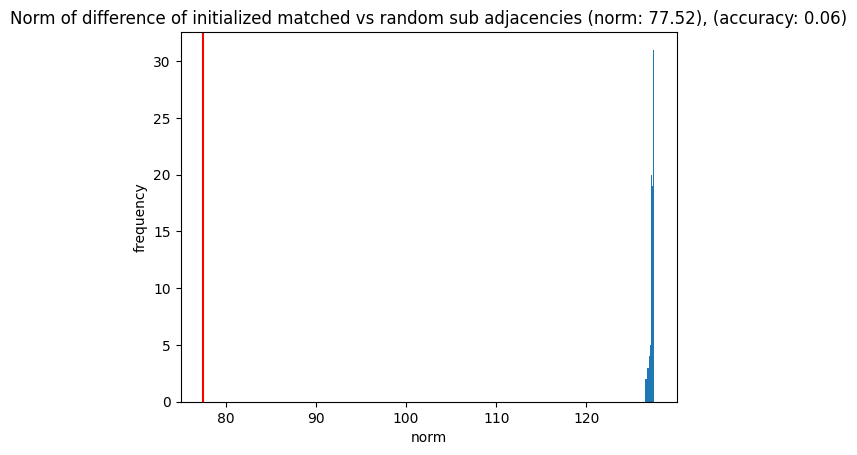

In [74]:
#histogram of SUB NADINE OPT
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_sub_nadine)
ax.axvline(sub_nadine_matched_norm_average, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of initialized matched vs random sub adjacencies (norm: {:.2f}), (accuracy: {:.2f})".format(sub_nadine_matched_norm_average, sub_nadine_matched_accuracy_average))

In [75]:
from numpy.random import default_rng

rng = default_rng()
numbers = rng.choice(20, size=10, replace=False)
numbers

array([ 2, 18,  4,  7,  9,  6,  1, 13, 14,  8])

In [76]:
x = np.linspace(0, 1, 3)
y = np.linspace(0, 1, 2)
xv, yv = np.meshgrid(x, y)
xv

array([[0. , 0.5, 1. ],
       [0. , 0.5, 1. ]])

In [77]:
n1 = np.arange(5)
n2 = np.arange(4)
a = np.arange(100)
a.shape = (10,10)
a[np.ix_(n1, n2)]

array([[ 0,  1,  2,  3],
       [10, 11, 12, 13],
       [20, 21, 22, 23],
       [30, 31, 32, 33],
       [40, 41, 42, 43]])

We will construct a permutation matrix P such that PBP^T causes correspondance to Nadine's pairs for both the subgraphs and the whole graphs

- Let's say we are at row i in our left subgraph, and obviously since this is a subgraph of the Nadine paired neurons, the skid of this row is going to be in the left true list since it has been matched by Nadine
    - If we go through the whole adjs, then if the left neuron is not in the true_pairs, then continue to next row in left graph
- Need to go through true_pairs to find the right neuron that our current left neuron corresponds to, and need to find the row where this neuron is in the right subgraph
    - In this row put a 1 in position i and a 0 everywhere else in the row
    - Keep track of the i's in which we fill the corresponding rows out
    - If we go through the right graph and the right neuron that we found earlier is not a skid in the right graph, then continue to next row in left graph
- In the rows of the right graph we did not examine put a 1 in a random spot that does not correspond to an i and 0's elsewhere
    - Keep track of each spot where the 1 was added in these random rows, cannot add a 1 in a differnt row in that same spot
- After constructing permutation matrix P, then do PBP^T, then do next steps



Optimization methods

- Nadine's pairs: make permutation matrix to correspond to Nadine's pairs in previous step and calculate accuracy and norm (can't do for default because need permutation matrix) (both subgraph and whole) (?)
- Opt: run graph matching and calculate accuracy and norm (for both default and Nadine permutation) (both subgraph and whole) see if score from graph matching with default initialization is worse than if initializing with permutation matrix
- Random: do random permutations of the rows of the right graph and calculate accuracy and norm (for both default and Nadine permutation) (both subgraph and whole)
- Focus on whole adjs

- Look at graph matching for the whole left and right graphs and compute accuracy and norm histogram (make sure to subset Nadine's true pairs correctly) (ensure accuracy is calculated correctly: look at picture of board to see how that is done)
- Show morphologies for 10 of the pairs that we matched that are not in Nadine's and 10 of the pairs that Nadine matched that are not in ours 
- Calculate norms for several situations (Nadine's subgraphs vs whole graphs, default init vs Nadine init (make permutation matrix such that PBP^T causes correspondance to Nadine's pairs (can verify with Pedigo after making)) optimization method (use nadine's pairs straightup on the subgraph, graph matching, random))
- (Note: when constructing permutation matrix to correspond to Nadine's pairs when using the entire whole graphs, can use random entries for the rows that do not correspond to Nadine's pairs (refer to "up" on graph: rows for permutation matrix there will be random))

- Make Gantt Chart timeline for what I need to get done
- Make permutation matrix by extracting the left and right skids and then rearranging the right skids such that it matches Nadine's pairs and then make adjacency matrix for right by reindexing, then the permutation matrix would be identity
- Get accuracies and norms for default and Nadine init with diff optimization methods (focus on Nadine's pairs and whole adjs), look at score from graph matching with default and see if worse than if initializing with permutation matrix 

- Go through Nadine's pairs, and find the pairs where the left neuron exists in our left skids and the right neurons exists in our right skids
    - L1: list of left neurons here, R1: list of right neurons here
- Go through our left and right skids, collect the skids that are not in L1 and R1, call these lists L2 and R2
- Shuffle L2 and R2
- L3 = L1 + L2, R3 = R1 + R2
- Extract adjacencies using these lists of skids using pymaid
- Run graph matching on adjacencies using an init parameter which will be an identity matrix the size of the larger of the two matrices
- Calculate norm and accuracy from graph matching

Do the initialization on the whole graph

In [78]:
#these are the lists of the skids that are paired in Nadine's lists, and both of the skids in the pair exist in our left and right lists respectively
whole_left_skids_in_pairs = []
whole_right_skids_in_pairs = []

#iterate through Nadine's list
for i in range(len(true_pairs)):
    if (true_pairs.loc[i, "skid-ID LEFT"] in left_skids and true_pairs.loc[i, "skid-ID RIGHT"] in right_skids):
        whole_left_skids_in_pairs.append(true_pairs.loc[i, "skid-ID LEFT"])
        whole_right_skids_in_pairs.append(true_pairs.loc[i, "skid-ID RIGHT"])

In [79]:
#get the list of skids in our left and right skids that are not in the lists we just made and shuffle them
whole_left_skids_not_pairs = np.array([skid for skid in left_skids if skid not in whole_left_skids_in_pairs])
whole_right_skids_not_pairs = np.array([skid for skid in right_skids if skid not in whole_right_skids_in_pairs])

whole_left_skids_not_pairs_rand_list = []
whole_right_skids_not_pairs_rand_list = []

#shuffle the lists n_iters times
for i in range(n_iters):
    rand_ind_left = rng.choice(len(whole_left_skids_not_pairs), size=len(whole_left_skids_not_pairs), replace=False)
    whole_left_skids_not_pairs_rand = whole_left_skids_not_pairs[rand_ind_left]
    whole_left_skids_not_pairs_rand_list.append(whole_left_skids_not_pairs_rand)

    rand_ind_right = rng.choice(len(whole_right_skids_not_pairs), size=len(whole_right_skids_not_pairs), replace=False)
    whole_right_skids_not_pairs_rand = whole_right_skids_not_pairs[rand_ind_right]
    whole_right_skids_not_pairs_rand_list.append(whole_right_skids_not_pairs_rand)

In [80]:
#concatenate the pairs and not pairs lists
whole_left_skids_to_match_list = []
whole_right_skids_to_match_list = []
whole_nadine_pairs_list = []

for i in range(n_iters):
    whole_left_skids_to_match = np.append(whole_left_skids_in_pairs, whole_left_skids_not_pairs_rand_list[i], axis=0)
    whole_left_skids_to_match_list.append(whole_left_skids_to_match)

    whole_right_skids_to_match = np.append(whole_right_skids_in_pairs, whole_right_skids_not_pairs_rand_list[i], axis=0)
    whole_right_skids_to_match_list.append(whole_right_skids_to_match)

    #Some of the last skids of the left list are removed so that the dimensions match in the dataframe
    whole_nadine_pairs = pd.DataFrame(list(zip(whole_left_skids_to_match, whole_right_skids_to_match)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    whole_nadine_pairs_list.append(whole_nadine_pairs)

Calculate the norm and accuracy of the initialized skids before graph matching

In [81]:
#WHOLE, NADINE, NADINE
whole_to_match_accuracy_list = []

for i in range(n_iters):
    #merge the true pairs and our matched pairs by their union
    whole_nadine_df = pd.merge(true_pairs, whole_nadine_pairs_list[i], on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

    #the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
    num = whole_nadine_df["Exist"].value_counts()["both"]

    #to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
    duplicate_L = whole_nadine_df[whole_nadine_df.duplicated("skid-ID LEFT")]
    duplicate_R = whole_nadine_df[whole_nadine_df.duplicated("skid-ID RIGHT")]

    #take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
    #repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
    duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

    #the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
    den = len(duplicate_df) + num
    whole_to_match_accuracy = num/den
    whole_to_match_accuracy_list.append(whole_to_match_accuracy)
    print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9239130434782609
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9272727272727272
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9272727272727272
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9239130434782609
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9306569343065694
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9239130434782609
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9205776173285198
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9306569343065694
The proportion of left right pairs from graph matching t

In [82]:
#norms of whole nadine init adjs
diff_whole_to_match_norm_list = []

for i in range(n_iters):
    #chop the last skids of the left skid list so the dimensions match
    whole_left_skids_to_match_trunc = whole_left_skids_to_match_list[i][0:len(whole_right_skids_to_match_list[i])]

    #make adjs from skids
    whole_left_adj_to_match = pymaid.adjacency_matrix(whole_left_skids_to_match_list[i])
    whole_left_adj_to_match_trunc = pymaid.adjacency_matrix(whole_left_skids_to_match_trunc)
    whole_right_adj_to_match = pymaid.adjacency_matrix(whole_right_skids_to_match_list[i])

    #convert adjs to numpy
    np_whole_left_adj_to_match = np.array(whole_left_adj_to_match)
    np_whole_left_adj_to_match_trunc = np.array(whole_left_adj_to_match_trunc)
    np_whole_right_adj_to_match = np.array(whole_right_adj_to_match)

    #calculate norm of difference of matched adjacencies
    np_diff_whole_nadine = np_whole_left_adj_to_match_trunc - np_whole_right_adj_to_match
    diff_whole_to_match_norm = np.linalg.norm(np_diff_whole_nadine)
    diff_whole_to_match_norm_list.append(diff_whole_to_match_norm)

    print(f"Norm of difference of left and right matched adjs: {diff_whole_to_match_norm}")

Norm of difference of left and right matched adjs: 206.5986447196593
Norm of difference of left and right matched adjs: 196.1708439090784
Norm of difference of left and right matched adjs: 206.97584400117807
Norm of difference of left and right matched adjs: 207.5789006618929
Norm of difference of left and right matched adjs: 205.7984450864486
Norm of difference of left and right matched adjs: 209.05262495362263
Norm of difference of left and right matched adjs: 208.5281755542881
Norm of difference of left and right matched adjs: 207.41745346040676
Norm of difference of left and right matched adjs: 207.4825293850063
Norm of difference of left and right matched adjs: 209.26538175245327


In [83]:
whole_left_skids_to_match_trunc[1200:1205]

array([], dtype='<U7')

In [84]:
whole_nadine_pairs

,skid-ID LEFT,skid-ID RIGHT
0,7501,25010
1,10536,26163
2,6743,23921
3,151847,27064
4,12115,27917
...,...,...
914,1916554,1448244
915,445828,762387
916,1741422,1302266
917,2001006,992383


In [85]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_sub_nadine = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):

    #randomly subset the truncated left adj
    rand_ind_left = rng.choice(len(np_whole_left_adj_to_match_trunc), size=len(np_whole_right_adj_to_match), replace=False)
    np_whole_nadine_left_adj_rand = np_whole_left_adj_to_match_trunc[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_whole_right_adj_to_match), size=len(np_whole_right_adj_to_match), replace=False)
    np_whole_nadine_right_adj_rand = np_whole_right_adj_to_match[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies
    np_whole_nadine_diff_adj_rand = np_whole_nadine_left_adj_rand - np_whole_nadine_right_adj_rand
    diff_whole_nadine_rand_norm = np.linalg.norm(np_whole_nadine_diff_adj_rand)
    rand_norms_whole_nadine.append(diff_whole_nadine_rand_norm)

In [86]:
diff_whole_to_match_norm_average = np.average(diff_whole_to_match_norm_list)
whole_to_match_accuracy_average = np.average(whole_to_match_accuracy)

Text(0.5, 1.0, 'Norm of difference of initialized vs random whole adjacencies (norm: 206.49), (accuracy: 0.93)')

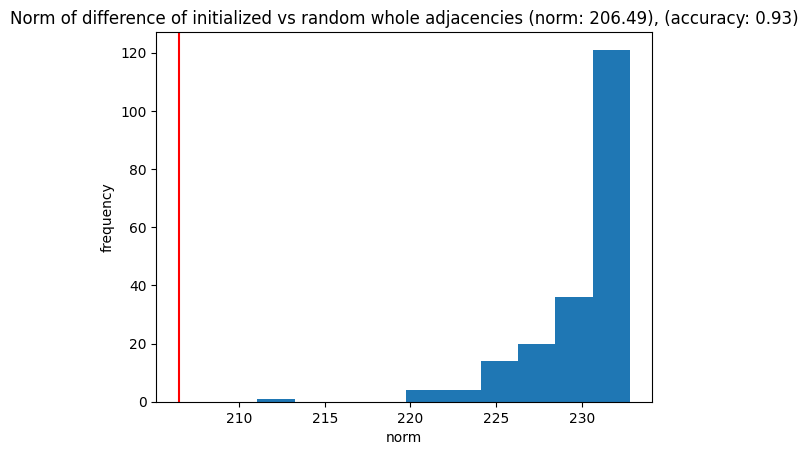

In [87]:
#histogram for WHOLE, NADINE, NADINE
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_whole_nadine)
ax.axvline(diff_whole_to_match_norm_average, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of initialized vs random whole adjacencies (norm: {:.2f}), (accuracy: {:.2f})".format(diff_whole_to_match_norm_average, whole_to_match_accuracy_average))

In [88]:
whole_nadine_ind_left_list = []
whole_nadine_ind_right_list = []
n_iters = 10
#make identity matrix that is the size of the bigger matrix as the permutation matrix to initialize graph matching
perm_mat = np.eye(max(len(whole_left_skids_to_match), len(whole_right_skids_to_match)))

In [89]:
#graph match with initialization on whole graph
for i in range(n_iters):
    whole_nadine_ind_left, whole_nadine_ind_right, whole_score_align, _ = graph_match(np_whole_left_adj_to_match, np_whole_right_adj_to_match, init=perm_mat)
    whole_nadine_ind_left_list.append(whole_nadine_ind_left)
    whole_nadine_ind_right_list.append(whole_nadine_ind_right)

In [90]:
whole_score_align

17253.0

In [91]:
whole_nadine_matched_pairs_list = []
for i in range(n_iters):
    whole_skids_left_form_matched = whole_left_skids_to_match[whole_nadine_ind_left_list[i]]
    whole_skids_right_form_matched = whole_right_skids_to_match[whole_nadine_ind_right_list[i]]

    #make dataframe for the matched pairs
    whole_nadine_matched_pairs = pd.DataFrame(list(zip(whole_skids_left_form_matched, whole_skids_right_form_matched)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    whole_nadine_matched_pairs_list.append(whole_nadine_matched_pairs)

In [92]:
#WHOLE, NADINE, OPT
whole_nadine_matched_accuracy_list = []
for i in range(n_iters):
    #merge the true pairs and our matched pairs by their union
    whole_nadine_matched_df = pd.merge(true_pairs, whole_nadine_matched_pairs_list[i], on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

    #the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
    num = whole_nadine_matched_df["Exist"].value_counts()["both"]

    #to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
    duplicate_L = whole_nadine_matched_df[whole_nadine_matched_df.duplicated("skid-ID LEFT")]
    duplicate_R = whole_nadine_matched_df[whole_nadine_matched_df.duplicated("skid-ID RIGHT")]

    #take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
    #repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
    duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

    #the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
    den = len(duplicate_df) + num
    whole_nadine_matched_accuracy = num/den
    whole_nadine_matched_accuracy_list.append(whole_nadine_matched_accuracy)
    print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.28415300546448086
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.25333333333333335
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.27197802197802196
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.27197802197802196
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.2661290322580645
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.2546916890080429
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.2650273224043716
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.2596685082872928
The proportion of left right pairs from graph matchi

In [93]:
#norms of whole init opt adjs
whole_nadine_matched_norm_list = []
for i in range(n_iters):
    #subset and permute the adjacencies by their indices from matching
    np_whole_nadine_matched_left_adj = np_whole_left_adj_to_match[np.ix_(whole_nadine_ind_left_list[i], whole_nadine_ind_left_list[i])]
    np_whole_nadine_matched_right_adj = np_whole_right_adj_to_match[np.ix_(whole_nadine_ind_right_list[i], whole_nadine_ind_right_list[i])]

    #calculate norm of difference of matched adjacencies
    np_whole_nadine_matched_diff = np_whole_nadine_matched_left_adj - np_whole_nadine_matched_right_adj
    diff_whole_nadine_matched_norm = np.linalg.norm(np_whole_nadine_matched_diff)
    whole_nadine_matched_norm_list.append(diff_whole_nadine_matched_norm)
    print(f"Norm of difference of left and right matched adjs: {diff_whole_nadine_matched_norm}")

Norm of difference of left and right matched adjs: 145.79094622095022


Norm of difference of left and right matched adjs: 143.11883174481267
Norm of difference of left and right matched adjs: 144.9586147836685
Norm of difference of left and right matched adjs: 143.1607488105591
Norm of difference of left and right matched adjs: 142.8775699681374
Norm of difference of left and right matched adjs: 143.24803663575986
Norm of difference of left and right matched adjs: 145.84923722803626
Norm of difference of left and right matched adjs: 143.15725619052637
Norm of difference of left and right matched adjs: 145.3375381654719
Norm of difference of left and right matched adjs: 142.97202523570826


In [94]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_whole_nadine = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_whole_left_adj_to_match), size=len(np_whole_right_adj_to_match), replace=False)
    np_whole_left_adj_to_match_rand = np_whole_left_adj_to_match[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_whole_right_adj_to_match), size=len(np_whole_right_adj_to_match), replace=False)
    np_whole_right_adj_to_match_rand = np_whole_right_adj_to_match[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_whole_nadine_diff_adj_rand = np_whole_left_adj_to_match_rand - np_whole_right_adj_to_match_rand
    diff_whole_nadine_rand_norm = np.linalg.norm(np_whole_nadine_diff_adj_rand)
    rand_norms_whole_nadine.append(diff_whole_nadine_rand_norm)

In [95]:
whole_nadine_matched_norm_average = np.average(whole_nadine_matched_norm_list)
whole_nadine_matched_accuracy_average = np.average(whole_nadine_matched_accuracy_list)

Text(0.5, 1.0, 'Norm of difference of initialized matched vs random whole adjacencies (norm: 144.05), (accuracy: 0.27)')

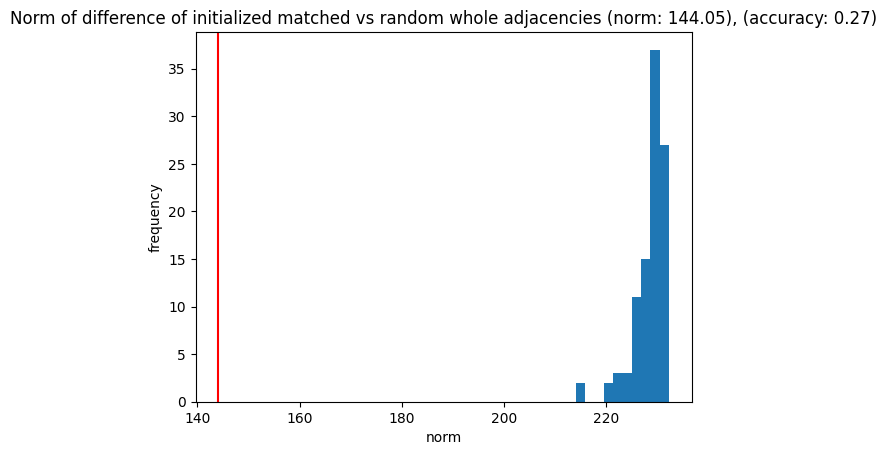

In [96]:
#histogram of WHOLE NADINE OPT
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_whole_nadine)
ax.axvline(whole_nadine_matched_norm_average, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of initialized matched vs random whole adjacencies (norm: {:.2f}), (accuracy: {:.2f})".format(whole_nadine_matched_norm_average, whole_nadine_matched_accuracy_average))

In [97]:
n_iters
perm_mat_seed = np.eye(len(np_whole_left_adj_to_match)-len(whole_left_skids_in_pairs))
len(perm_mat_seed)

712

In [98]:
#seeded graph matching
partial_match_whole = np.stack(
    (np.arange(len(whole_left_skids_in_pairs)), np.arange(len(whole_right_skids_in_pairs)))
).T

whole_nadine_ind_left_seed_list = []
whole_nadine_ind_right_seed_list = []
for i in range(n_iters):
    whole_nadine_ind_left_seed, whole_nadine_ind_right_seed, whole_score_seed, _ = graph_match(np_whole_left_adj_to_match, np_whole_right_adj_to_match, partial_match=partial_match_whole)
    whole_nadine_ind_left_seed_list.append(whole_nadine_ind_left_seed)
    whole_nadine_ind_right_seed_list.append(whole_nadine_ind_right_seed)

In [99]:
print(whole_score_seed)

15951.0


In [100]:
whole_nadine_matched_pairs_seed_list = []
for i in range(n_iters):
    whole_skids_left_form_matched_seed = whole_left_skids_to_match[whole_nadine_ind_left_seed_list[i]]
    whole_skids_right_form_matched_seed = whole_right_skids_to_match[whole_nadine_ind_right_seed_list[i]]

    #make dataframe for the matched pairs
    whole_nadine_matched_pairs_seed = pd.DataFrame(list(zip(whole_skids_left_form_matched_seed, whole_skids_right_form_matched_seed)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    whole_nadine_matched_pairs_seed_list.append(whole_nadine_matched_pairs_seed)

In [101]:
#WHOLE, NADINE, SEED
whole_nadine_matched_seed_accuracy_list = []
for i in range(n_iters):
    #merge the true pairs and our matched pairs by their union
    whole_nadine_matched_seed_df = pd.merge(true_pairs, whole_nadine_matched_pairs_seed_list[i], on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

    #the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
    num = whole_nadine_matched_seed_df["Exist"].value_counts()["both"]

    #to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
    duplicate_L = whole_nadine_matched_seed_df[whole_nadine_matched_seed_df.duplicated("skid-ID LEFT")]
    duplicate_R = whole_nadine_matched_seed_df[whole_nadine_matched_seed_df.duplicated("skid-ID RIGHT")]

    #take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
    #repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
    duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

    #the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
    den = len(duplicate_df) + num
    whole_nadine_matched_seed_accuracy = num/den
    whole_nadine_matched_seed_accuracy_list.append(whole_nadine_matched_seed_accuracy)
    print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9239130434782609
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9239130434782609
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9239130434782609
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9205776173285198
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9272727272727272
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9205776173285198
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9239130434782609
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9239130434782609
The proportion of left right pairs from graph matching t

In [102]:
#norms of whole init seed adjs
whole_nadine_matched_seed_norm_list = []
for i in range(n_iters):
    #subset and permute the adjacencies by their indices from matching
    np_whole_nadine_matched_seed_left_adj = np_whole_left_adj_to_match[np.ix_(whole_nadine_ind_left_seed_list[i], whole_nadine_ind_left_seed_list[i])]
    np_whole_nadine_matched_seed_right_adj = np_whole_right_adj_to_match[np.ix_(whole_nadine_ind_right_seed_list[i], whole_nadine_ind_right_seed_list[i])]

    #calculate norm of difference of matched adjacencies
    np_whole_nadine_matched_seed_diff = np_whole_nadine_matched_seed_left_adj - np_whole_nadine_matched_seed_right_adj
    diff_whole_nadine_matched_seed_norm = np.linalg.norm(np_whole_nadine_matched_seed_diff)
    whole_nadine_matched_seed_norm_list.append(diff_whole_nadine_matched_seed_norm)
    print(f"Norm of difference of left and right matched adjs: {diff_whole_nadine_matched_seed_norm}")

Norm of difference of left and right matched adjs: 151.99013125857877
Norm of difference of left and right matched adjs: 152.17424223566877
Norm of difference of left and right matched adjs: 152.10851389715174
Norm of difference of left and right matched adjs: 151.92432326655268
Norm of difference of left and right matched adjs: 152.34828518890524
Norm of difference of left and right matched adjs: 151.93090534845106
Norm of difference of left and right matched adjs: 152.07892687680302
Norm of difference of left and right matched adjs: 151.81238421156556
Norm of difference of left and right matched adjs: 152.07892687680302
Norm of difference of left and right matched adjs: 151.75967843930087


In [103]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_whole_nadine = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_whole_left_adj_to_match), size=len(np_whole_right_adj_to_match), replace=False)
    np_whole_left_adj_to_match_rand = np_whole_left_adj_to_match[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_whole_right_adj_to_match), size=len(np_whole_right_adj_to_match), replace=False)
    np_whole_right_adj_to_match_rand = np_whole_right_adj_to_match[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_whole_nadine_diff_adj_rand = np_whole_left_adj_to_match_rand - np_whole_right_adj_to_match_rand
    diff_whole_nadine_rand_norm = np.linalg.norm(np_whole_nadine_diff_adj_rand)
    rand_norms_whole_nadine.append(diff_whole_nadine_rand_norm)

In [104]:
whole_nadine_matched_seed_norm_average = np.average(whole_nadine_matched_seed_norm_list)
whole_nadine_matched_seed_accuracy_average = np.average(whole_nadine_matched_seed_accuracy_list)

Text(0.5, 1.0, 'Norm of difference of seeded matched vs random whole adjacencies (norm: 152.02), (accuracy: 0.92)')

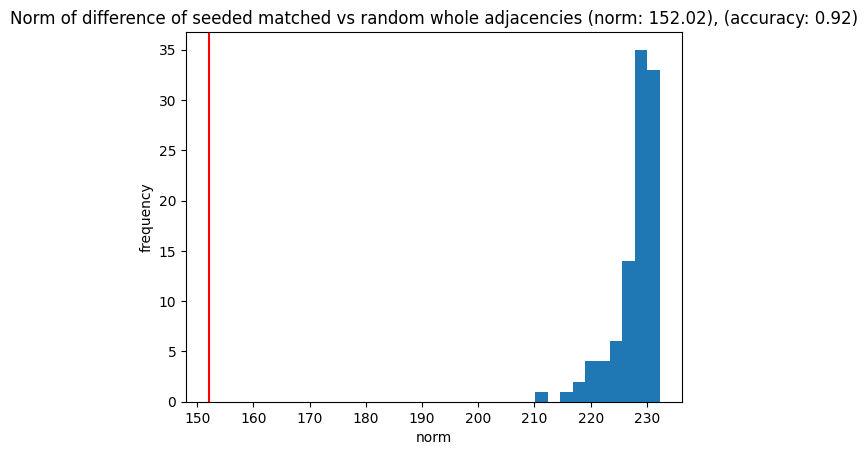

In [105]:
#histogram of WHOLE NADINE SEED
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_whole_nadine)
ax.axvline(whole_nadine_matched_seed_norm_average, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of seeded matched vs random whole adjacencies (norm: {:.2f}), (accuracy: {:.2f})".format(whole_nadine_matched_seed_norm_average, whole_nadine_matched_seed_accuracy_average))

<AxesSubplot:>

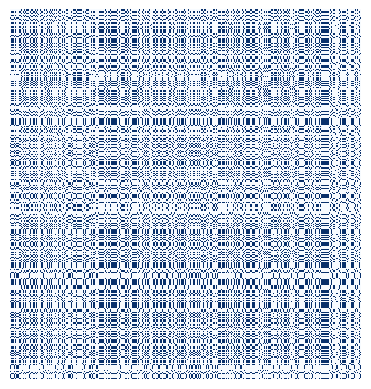

In [161]:
#whole class similarity
whole_class_similarity = (np_left_labels[:, None] == np_right_labels[None, :])

sns.heatmap(
    whole_class_similarity,
    cmap="Blues",
    cbar=False,
    square=True,
    xticklabels=False,
    yticklabels=False,
)

In [162]:
whole_nadine_ind_left_class_list = []
whole_nadine_ind_right_class_list = []
for i in range(n_iters):
    whole_nadine_ind_left_class, whole_nadine_ind_right_class, whole_score_class, _ = graph_match(np_whole_left_adj_to_match, np_whole_right_adj_to_match, S=whole_class_similarity, verbose=3)
    whole_nadine_ind_left_class_list.append(whole_nadine_ind_left_class)
    whole_nadine_ind_right_class_list.append(whole_nadine_ind_right_class)

[Pre-loop] Initializing
   [Pre-loop] Computing constant terms
   [Iteration: 1] Computing gradient
   [Iteration: 1] Solving assignment problem
   [Iteration: 1] Computing step size
   [Iteration: 2] Computing gradient
   [Iteration: 2] Solving assignment problem
   [Iteration: 2] Computing step size
   [Iteration: 3] Computing gradient
   [Iteration: 3] Solving assignment problem
   [Iteration: 3] Computing step size
   [Iteration: 4] Computing gradient
   [Iteration: 4] Solving assignment problem
   [Iteration: 4] Computing step size
   [Iteration: 5] Computing gradient
   [Iteration: 5] Solving assignment problem
   [Iteration: 5] Computing step size
   [Iteration: 6] Computing gradient
   [Iteration: 6] Solving assignment problem
   [Iteration: 6] Computing step size
   [Iteration: 7] Computing gradient
   [Iteration: 7] Solving assignment problem
   [Iteration: 7] Computing step size
   [Iteration: 8] Computing gradient
   [Iteration: 8] Solving assignment problem
   [Iteration: 

In [163]:
print(whole_score_class)

14885.0


In [164]:
whole_nadine_matched_pairs_class_list = []
for i in range(n_iters):
    whole_skids_left_form_matched_class = whole_left_skids_to_match[whole_nadine_ind_left_class_list[i]]
    whole_skids_right_form_matched_class = whole_right_skids_to_match[whole_nadine_ind_right_class_list[i]]

    #make dataframe for the matched pairs
    whole_nadine_matched_pairs_class = pd.DataFrame(list(zip(whole_skids_left_form_matched_class, whole_skids_right_form_matched_class)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    whole_nadine_matched_pairs_class_list.append(whole_nadine_matched_pairs_class)

In [173]:
#WHOLE, NADINE, CLASS
whole_nadine_matched_class_accuracy_list = []
for i in range(n_iters):
    #merge the true pairs and our matched pairs by their union
    whole_nadine_matched_class_df = pd.merge(true_pairs, whole_nadine_matched_pairs_class_list[i], on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

    #the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
    num = whole_nadine_matched_class_df["Exist"].value_counts()["both"]

    #to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
    duplicate_L = whole_nadine_matched_class_df[whole_nadine_matched_class_df.duplicated("skid-ID LEFT")]
    duplicate_R = whole_nadine_matched_class_df[whole_nadine_matched_class_df.duplicated("skid-ID RIGHT")]

    #take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
    #repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
    duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

    #the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
    den = len(duplicate_df) + num
    whole_nadine_matched_class_accuracy = num/den
    whole_nadine_matched_class_accuracy_list.append(whole_nadine_matched_class_accuracy)
    print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.0071090047393364926
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.002347417840375587
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.0023584905660377358
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.0023584905660377358
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.002325581395348837
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.002320185614849188
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.004728132387706856
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.00228310502283105
The proportion of left right pairs fro

In [167]:
#norms of whole init class adjs
whole_nadine_matched_class_norm_list = []
for i in range(n_iters):
    #subset and permute the adjacencies by their indices from matching
    np_whole_nadine_matched_class_left_adj = np_whole_left_adj_to_match[np.ix_(whole_nadine_ind_left_class_list[i], whole_nadine_ind_left_class_list[i])]
    np_whole_nadine_matched_class_right_adj = np_whole_right_adj_to_match[np.ix_(whole_nadine_ind_right_class_list[i], whole_nadine_ind_right_class_list[i])]

    #calculate norm of difference of matched adjacencies
    np_whole_nadine_matched_class_diff = np_whole_nadine_matched_class_left_adj - np_whole_nadine_matched_class_right_adj
    diff_whole_nadine_matched_class_norm = np.linalg.norm(np_whole_nadine_matched_class_diff)
    whole_nadine_matched_class_norm_list.append(diff_whole_nadine_matched_class_norm)
    print(f"Norm of difference of left and right matched adjs: {diff_whole_nadine_matched_class_norm}")

Norm of difference of left and right matched adjs: 162.37610661670638
Norm of difference of left and right matched adjs: 161.85178404948152
Norm of difference of left and right matched adjs: 161.5116094898444
Norm of difference of left and right matched adjs: 161.35055004554525
Norm of difference of left and right matched adjs: 161.10245187457576
Norm of difference of left and right matched adjs: 161.5704180844996
Norm of difference of left and right matched adjs: 162.31758992789415
Norm of difference of left and right matched adjs: 161.83324751113412
Norm of difference of left and right matched adjs: 161.69724796668618
Norm of difference of left and right matched adjs: 162.32375057273657


In [168]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_whole_nadine = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_whole_left_adj_to_match), size=len(np_whole_right_adj_to_match), replace=False)
    np_whole_left_adj_to_match_rand = np_whole_left_adj_to_match[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_whole_right_adj_to_match), size=len(np_whole_right_adj_to_match), replace=False)
    np_whole_right_adj_to_match_rand = np_whole_right_adj_to_match[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_whole_nadine_diff_adj_rand = np_whole_left_adj_to_match_rand - np_whole_right_adj_to_match_rand
    diff_whole_nadine_rand_norm = np.linalg.norm(np_whole_nadine_diff_adj_rand)
    rand_norms_whole_nadine.append(diff_whole_nadine_rand_norm)

In [169]:
whole_nadine_matched_class_norm_average = np.average(whole_nadine_matched_class_norm_list)
whole_nadine_matched_class_accuracy_average = np.average(whole_nadine_matched_class_accuracy_list)

Text(0.5, 1.0, 'Norm of difference of matched vs random whole adjacencies with class similarity (norm: 161.79), (accuracy: 0.00)')

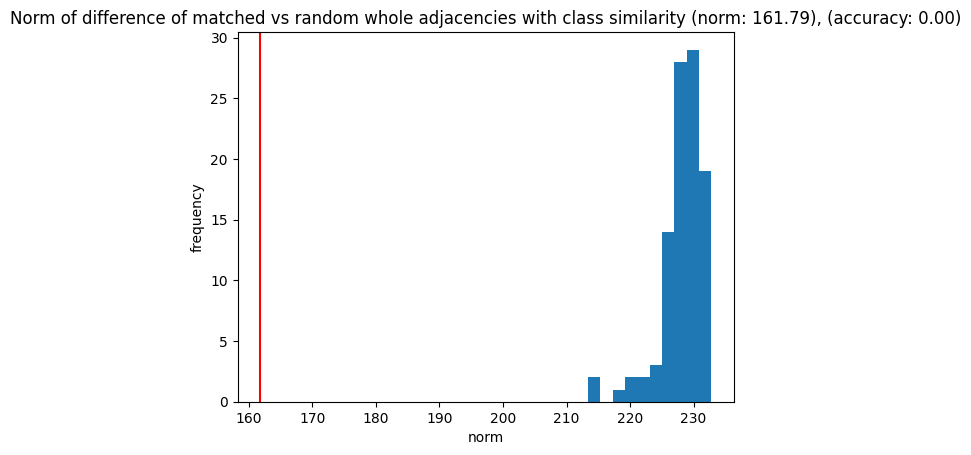

In [170]:
#histogram of WHOLE NADINE CLASS
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_whole_nadine)
ax.axvline(whole_nadine_matched_class_norm_average, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of matched vs random whole adjacencies with class similarity (norm: {:.2f}), (accuracy: {:.2f})".format(whole_nadine_matched_class_norm_average, whole_nadine_matched_class_accuracy_average))

Now we do the same initialization but on the subgraph of the left and right neurons

In [106]:
#these are the lists of the skids that are paired in Nadine's lists, and both of the skids in the pair exist in our left and right lists respectively
sub_left_skids_in_pairs = []
sub_right_skids_in_pairs = []

for i in range(len(true_pairs)):
    if (true_pairs.loc[i, "skid-ID LEFT"] in sub_left_skids and true_pairs.loc[i, "skid-ID RIGHT"] in sub_right_skids):
        sub_left_skids_in_pairs.append(true_pairs.loc[i, "skid-ID LEFT"])
        sub_right_skids_in_pairs.append(true_pairs.loc[i, "skid-ID RIGHT"])

In [107]:
#get the list of skids in our left and right skids that are not in the lists we just made and shuffle them
sub_left_skids_not_pairs = np.array([skid for skid in sub_left_skids if skid not in sub_left_skids_in_pairs])
sub_right_skids_not_pairs = np.array([skid for skid in sub_right_skids if skid not in sub_right_skids_in_pairs])

sub_left_skids_not_pairs_rand_list = []
sub_right_skids_not_pairs_rand_list = []

#shuffle the lists n_iters times
for i in range(n_iters):
    rand_ind_left = rng.choice(len(sub_left_skids_not_pairs), size=len(sub_left_skids_not_pairs), replace=False)
    sub_left_skids_not_pairs_rand = sub_left_skids_not_pairs[rand_ind_left]
    sub_left_skids_not_pairs_rand_list.append(sub_left_skids_not_pairs_rand)

    rand_ind_right = rng.choice(len(sub_right_skids_not_pairs), size=len(sub_right_skids_not_pairs), replace=False)
    sub_right_skids_not_pairs_rand = sub_right_skids_not_pairs[rand_ind_right]
    sub_right_skids_not_pairs_rand_list.append(sub_right_skids_not_pairs_rand)

In [108]:
#concatenate the pairs and not pairs lists
sub_left_skids_to_match_list = []
sub_right_skids_to_match_list = []
sub_nadine_pairs_list = []

for i in range(n_iters):
    sub_left_skids_to_match = np.append(sub_left_skids_in_pairs, sub_left_skids_not_pairs_rand_list[i], axis=0)
    sub_left_skids_to_match_list.append(sub_left_skids_to_match)

    sub_right_skids_to_match = np.append(sub_right_skids_in_pairs, sub_right_skids_not_pairs_rand_list[i], axis=0)
    sub_right_skids_to_match_list.append(sub_right_skids_to_match)

    sub_nadine_pairs = pd.DataFrame(list(zip(sub_left_skids_to_match, sub_right_skids_to_match)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    sub_nadine_pairs_list.append(sub_nadine_pairs)

In [109]:
#SUB, NADINE, NADINE
sub_to_match_accuracy_list = []

for i in range(n_iters):
    #merge the true pairs and our matched pairs by their union
    sub_nadine_df = pd.merge(true_pairs, sub_nadine_pairs_list[i], on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

    #the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
    num = sub_nadine_df["Exist"].value_counts()["both"]

    #to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
    duplicate_L = sub_nadine_df[sub_nadine_df.duplicated("skid-ID LEFT")]
    duplicate_R = sub_nadine_df[sub_nadine_df.duplicated("skid-ID RIGHT")]

    #take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
    #repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
    duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

    #the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
    den = len(duplicate_df) + num
    sub_to_match_accuracy = num/den
    sub_to_match_accuracy_list.append(sub_to_match_accuracy)
    print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9807692307692307
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9807692307692307
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9807692307692307
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9807692307692307
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9807692307692307
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9807692307692307
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9807692307692307
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9807692307692307
The proportion of left right pairs from graph matching t

In [110]:
#norms of sub nadine init adjs
diff_sub_to_match_norm_list = []
np_sub_left_adj_to_match_list = []
np_sub_left_adj_to_match_trunc_list = []
np_sub_right_adj_to_match_list = []

for i in range(n_iters):
    #chop the last skids of the left skid list so the dimensions match
    sub_left_skids_to_match_trunc = sub_left_skids_to_match_list[i][0:len(sub_right_skids_to_match_list[i])]

    #make adjs
    sub_left_adj_to_match = pymaid.adjacency_matrix(sub_left_skids_to_match_list[i])
    sub_left_adj_to_match_trunc = pymaid.adjacency_matrix(sub_left_skids_to_match_trunc)
    sub_right_adj_to_match = pymaid.adjacency_matrix(sub_right_skids_to_match_list[i])

    np_sub_left_adj_to_match = np.array(sub_left_adj_to_match)
    np_sub_left_adj_to_match_trunc = np.array(sub_left_adj_to_match_trunc)
    np_sub_right_adj_to_match = np.array(sub_right_adj_to_match)

    np_sub_left_adj_to_match_list.append(np_sub_left_adj_to_match)
    np_sub_left_adj_to_match_trunc_list.append(np_sub_left_adj_to_match_trunc)
    np_sub_right_adj_to_match_list.append(np_sub_right_adj_to_match)

    #calculate norm of difference of matched adjacencies
    np_diff_sub_nadine = np_sub_left_adj_to_match_trunc - np_sub_right_adj_to_match
    diff_sub_to_match_norm = np.linalg.norm(np_diff_sub_nadine)
    diff_sub_to_match_norm_list.append(diff_sub_to_match_norm)

    print(f"Norm of difference of left and right matched adjs: {diff_sub_to_match_norm}")

Norm of difference of left and right matched adjs: 77.59510293826537
Norm of difference of left and right matched adjs: 77.12327793863537
Norm of difference of left and right matched adjs: 77.07139547199077
Norm of difference of left and right matched adjs: 77.0454411370329
Norm of difference of left and right matched adjs: 78.06407624509497
Norm of difference of left and right matched adjs: 77.00649323271382
Norm of difference of left and right matched adjs: 77.50483855863452
Norm of difference of left and right matched adjs: 77.12976079309465
Norm of difference of left and right matched adjs: 77.54998388136518
Norm of difference of left and right matched adjs: 77.62087348130012


In [111]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_sub_nadine = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_sub_left_adj_to_match_trunc), size=len(np_sub_right_adj_to_match), replace=False)
    np_sub_nadine_left_adj_rand = np_sub_left_adj_to_match_trunc[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_sub_right_adj_to_match), size=len(np_sub_right_adj_to_match), replace=False)
    np_sub_nadine_right_adj_rand = np_sub_right_adj_to_match[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_sub_nadine_diff_adj_rand = np_sub_nadine_left_adj_rand - np_sub_nadine_right_adj_rand
    diff_sub_nadine_rand_norm = np.linalg.norm(np_sub_nadine_diff_adj_rand)
    rand_norms_sub_nadine.append(diff_sub_nadine_rand_norm)

In [112]:
diff_sub_to_match_norm_average = np.average(diff_sub_to_match_norm_list)
sub_to_match_accuracy_average = np.average(sub_to_match_accuracy_list)

Text(0.5, 1.0, 'Norm of difference of initialized vs random sub adjacencies (norm: 77.37), (accuracy: 0.98)')

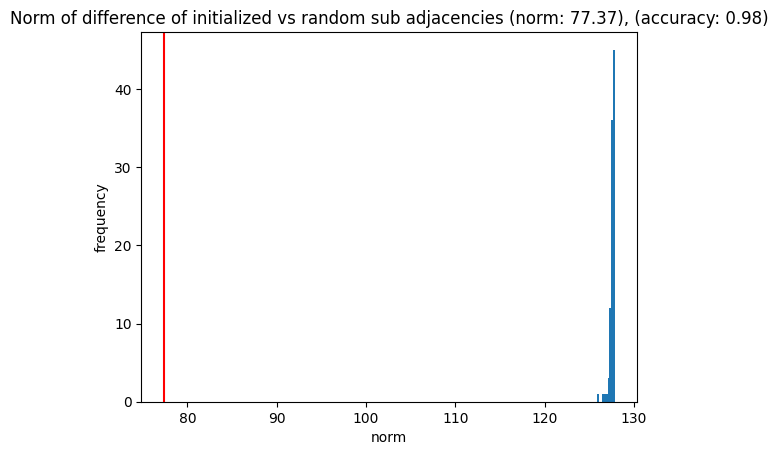

In [113]:
#histogram of SUB NADINE NADINE
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_sub_nadine)
ax.axvline(diff_sub_to_match_norm_average, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of initialized vs random sub adjacencies (norm: {:.2f}), (accuracy: {:.2f})".format(diff_sub_to_match_norm_average, sub_to_match_accuracy_average))

In [114]:
sub_nadine_ind_left_list = []
sub_nadine_ind_right_list = []

#make identity matrix that is the size of the bigger matrix as the permutation matrix to initialize graph matching
sub_perm_mat = np.eye(max(len(sub_left_skids_to_match), len(sub_right_skids_to_match)))

In [115]:
#graph match with initialization on subgraphs
for i in range(n_iters):
    sub_nadine_ind_left, sub_nadine_ind_right, sub_score_align, _ = graph_match(np_sub_left_adj_to_match, np_sub_right_adj_to_match, init=sub_perm_mat)
    sub_nadine_ind_left_list.append(sub_nadine_ind_left)
    sub_nadine_ind_right_list.append(sub_nadine_ind_right)

In [116]:
sub_score_align

5844.0

In [117]:
sub_nadine_matched_pairs_list = []
for i in range(n_iters):
    sub_skids_left_form_matched = sub_left_skids_to_match[sub_nadine_ind_left_list[i]]
    sub_skids_right_form_matched = sub_right_skids_to_match[sub_nadine_ind_right_list[i]]

    #make dataframe for the matched pairs
    sub_nadine_matched_pairs = pd.DataFrame(list(zip(sub_skids_left_form_matched, sub_skids_right_form_matched)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    sub_nadine_matched_pairs_list.append(sub_nadine_matched_pairs)

In [118]:
#SUB, NADINE, OPT
sub_nadine_matched_accuracy_list = []
for i in range(n_iters):
    #merge the true pairs and our matched pairs by their union
    sub_nadine_matched_df = pd.merge(true_pairs, sub_nadine_matched_pairs_list[i], on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

    #the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
    num = sub_nadine_matched_df["Exist"].value_counts()["both"]
    #to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
    duplicate_L = sub_nadine_matched_df[sub_nadine_matched_df.duplicated("skid-ID LEFT")]
    duplicate_R = sub_nadine_matched_df[sub_nadine_matched_df.duplicated("skid-ID RIGHT")]

    #take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
    #repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
    duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

    #the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
    den = len(duplicate_df) + num
    sub_nadine_matched_accuracy = num/den
    sub_nadine_matched_accuracy_list.append(sub_nadine_matched_accuracy)
    print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.4269230769230769
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.4269230769230769
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.4076923076923077
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.4307692307692308
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.41923076923076924
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.4153846153846154
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.40384615384615385
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.4076923076923077
The proportion of left right pairs from graph matching

In [119]:
#norms of sub init opt adjs
sub_nadine_matched_norm_list = []
for i in range(n_iters):
    #subset and permute the adjacencies by their indices from matching
    np_sub_nadine_matched_left_adj = np_sub_left_adj_to_match[np.ix_(sub_nadine_ind_left_list[i], sub_nadine_ind_left_list[i])]
    np_sub_nadine_matched_right_adj = np_sub_right_adj_to_match[np.ix_(sub_nadine_ind_right_list[i], sub_nadine_ind_right_list[i])]

    #calculate norm of difference of matched adjacencies
    np_sub_nadine_matched_diff = np_sub_nadine_matched_left_adj - np_sub_nadine_matched_right_adj
    diff_sub_nadine_matched_norm = np.linalg.norm(np_sub_nadine_matched_diff)
    sub_nadine_matched_norm_list.append(diff_sub_nadine_matched_norm)
    print(f"Norm of difference of left and right matched adjs: {diff_sub_nadine_matched_norm}")

Norm of difference of left and right matched adjs: 68.45436436049933
Norm of difference of left and right matched adjs: 68.38859554048467
Norm of difference of left and right matched adjs: 68.59300255857006
Norm of difference of left and right matched adjs: 68.5200700525036
Norm of difference of left and right matched adjs: 68.4470598345904
Norm of difference of left and right matched adjs: 68.22756041366274
Norm of difference of left and right matched adjs: 68.47627326307996
Norm of difference of left and right matched adjs: 68.41052550594829


Norm of difference of left and right matched adjs: 68.22756041366274
Norm of difference of left and right matched adjs: 68.65129277733959


In [120]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_sub_nadine = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_sub_left_adj_to_match), size=len(np_sub_right_adj_to_match), replace=False)
    np_sub_left_adj_to_match_rand = np_sub_left_adj_to_match[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_sub_right_adj_to_match), size=len(np_sub_right_adj_to_match), replace=False)
    np_sub_right_adj_to_match_rand = np_sub_right_adj_to_match[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_sub_nadine_diff_adj_rand = np_sub_left_adj_to_match_rand - np_sub_right_adj_to_match_rand
    diff_sub_nadine_rand_norm = np.linalg.norm(np_sub_nadine_diff_adj_rand)
    rand_norms_sub_nadine.append(diff_sub_nadine_rand_norm)

In [121]:
sub_nadine_matched_norm_average = np.average(sub_nadine_matched_norm_list)
sub_nadine_matched_accuracy_average = np.average(sub_nadine_matched_accuracy_list)

Text(0.5, 1.0, 'Norm of difference of initialized matched vs random sub adjacencies (norm: 68.44), (accuracy: 0.42)')

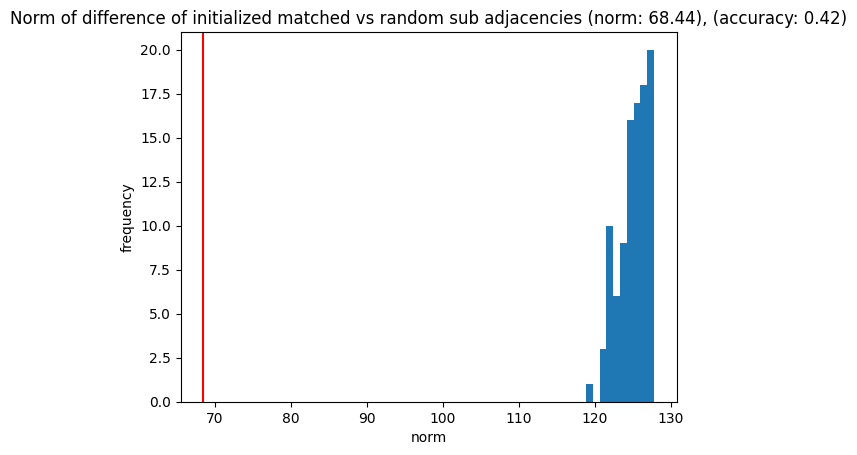

In [122]:
#histogram of SUB INIT OPT
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_sub_nadine)
ax.axvline(sub_nadine_matched_norm_average, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of initialized matched vs random sub adjacencies (norm: {:.2f}), (accuracy: {:.2f})".format(sub_nadine_matched_norm_average, sub_nadine_matched_accuracy_average))

In [123]:
#seeded graph matching
partial_match_sub = np.stack(
    (np.arange(len(sub_left_skids_in_pairs)), np.arange(len(sub_right_skids_in_pairs)))
).T

sub_nadine_ind_left_seed_list = []
sub_nadine_ind_right_seed_list = []
for i in range(n_iters):
    sub_nadine_ind_left_seed, sub_nadine_ind_right_seed, sub_score_seed, _ = graph_match(np_sub_left_adj_to_match, np_sub_right_adj_to_match, partial_match=partial_match_sub)
    sub_nadine_ind_left_seed_list.append(sub_nadine_ind_left_seed)
    sub_nadine_ind_right_seed_list.append(sub_nadine_ind_right_seed)

In [124]:
sub_score_seed

5162.0

In [125]:
sub_nadine_matched_pairs_seed_list = []
for i in range(n_iters):
    sub_skids_left_form_matched_seed = sub_left_skids_to_match[sub_nadine_ind_left_seed_list[i]]
    sub_skids_right_form_matched_seed = sub_right_skids_to_match[sub_nadine_ind_right_seed_list[i]]

    #make dataframe for the matched pairs
    sub_nadine_matched_pairs_seed = pd.DataFrame(list(zip(sub_skids_left_form_matched_seed, sub_skids_right_form_matched_seed)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    sub_nadine_matched_pairs_seed_list.append(sub_nadine_matched_pairs_seed)

In [126]:
#SUB, NADINE, OPT
sub_nadine_matched_seed_accuracy_list = []
for i in range(n_iters):
    #merge the true pairs and our matched pairs by their union
    sub_nadine_matched_seed_df = pd.merge(true_pairs, sub_nadine_matched_pairs_seed_list[i], on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

    #the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
    num = sub_nadine_matched_seed_df["Exist"].value_counts()["both"]

    #to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
    duplicate_L = sub_nadine_matched_seed_df[sub_nadine_matched_seed_df.duplicated("skid-ID LEFT")]
    duplicate_R = sub_nadine_matched_seed_df[sub_nadine_matched_seed_df.duplicated("skid-ID RIGHT")]

    #take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
    #repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
    duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

    #the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
    den = len(duplicate_df) + num
    sub_nadine_matched_seed_accuracy = num/den
    sub_nadine_matched_seed_accuracy_list.append(sub_nadine_matched_seed_accuracy)
    print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9807692307692307
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9807692307692307
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9807692307692307
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9807692307692307
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9807692307692307
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9807692307692307
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9807692307692307
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9807692307692307
The proportion of left right pairs from graph matching t

In [127]:
#norms of sub init seed adjs
sub_nadine_matched_seed_norm_list = []
for i in range(n_iters):
    #subset and permute the adjacencies by their indices from matching
    np_sub_nadine_matched_seed_left_adj = np_sub_left_adj_to_match[np.ix_(sub_nadine_ind_left_seed_list[i], sub_nadine_ind_left_seed_list[i])]
    np_sub_nadine_matched_seed_right_adj = np_sub_right_adj_to_match[np.ix_(sub_nadine_ind_right_seed_list[i], sub_nadine_ind_right_seed_list[i])]

    #calculate norm of difference of matched adjacencies
    np_sub_nadine_matched_seed_diff = np_sub_nadine_matched_seed_left_adj - np_sub_nadine_matched_seed_right_adj
    diff_sub_nadine_matched_seed_norm = np.linalg.norm(np_sub_nadine_matched_seed_diff)
    sub_nadine_matched_seed_norm_list.append(diff_sub_nadine_matched_seed_norm)
    print(f"Norm of difference of left and right matched adjs: {diff_sub_nadine_matched_seed_norm}")

Norm of difference of left and right matched adjs: 77.13624310270757
Norm of difference of left and right matched adjs: 77.03895118704564
Norm of difference of left and right matched adjs: 77.03895118704564
Norm of difference of left and right matched adjs: 77.9615289742319
Norm of difference of left and right matched adjs: 77.0454411370329
Norm of difference of left and right matched adjs: 77.49838707999025
Norm of difference of left and right matched adjs: 77.03895118704564
Norm of difference of left and right matched adjs: 77.05193054038295
Norm of difference of left and right matched adjs: 77.49838707999025
Norm of difference of left and right matched adjs: 77.07788269017254


In [128]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_sub_nadine = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_sub_left_adj_to_match_trunc), size=len(np_sub_right_adj_to_match), replace=False)
    np_sub_nadine_left_adj_rand = np_sub_left_adj_to_match_trunc[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_sub_right_adj_to_match), size=len(np_sub_right_adj_to_match), replace=False)
    np_sub_nadine_right_adj_rand = np_sub_right_adj_to_match[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_sub_nadine_diff_adj_rand = np_sub_nadine_left_adj_rand - np_sub_nadine_right_adj_rand
    diff_sub_nadine_rand_norm = np.linalg.norm(np_sub_nadine_diff_adj_rand)
    rand_norms_sub_nadine.append(diff_sub_nadine_rand_norm)

In [129]:
sub_nadine_matched_seed_norm_average = np.average(sub_nadine_matched_seed_norm_list)
sub_nadine_matched_seed_accuracy_average = np.average(sub_nadine_matched_seed_accuracy_list)

Text(0.5, 1.0, 'Norm of difference of seeded matched vs random sub adjacencies (norm: 77.24), (accuracy: 0.98)')

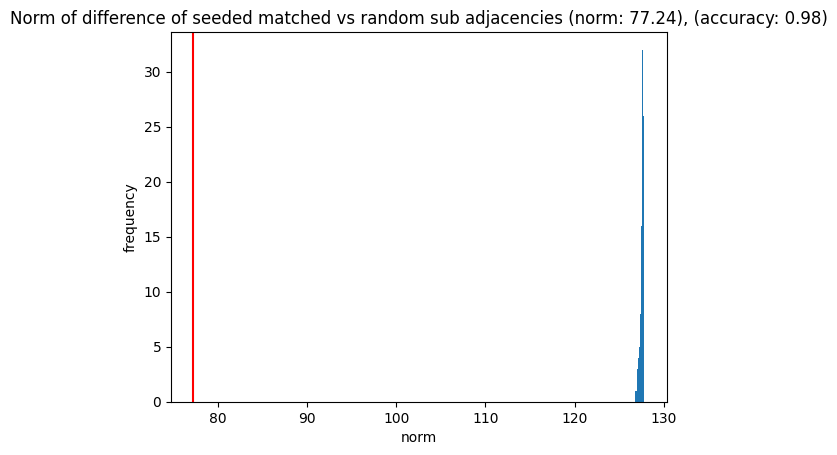

In [130]:
#histogram of SUB NADINE SEED
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_sub_nadine)
ax.axvline(sub_nadine_matched_seed_norm_average, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of seeded matched vs random sub adjacencies (norm: {:.2f}), (accuracy: {:.2f})".format(sub_nadine_matched_seed_norm_average, sub_nadine_matched_seed_accuracy_average))

<AxesSubplot:>

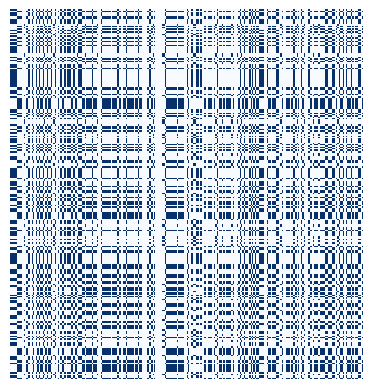

In [171]:
#sub class similarity
sub_class_similarity = (sub_left_labels[:, None] == sub_right_labels[None, :])

sns.heatmap(
    sub_class_similarity,
    cmap="Blues",
    cbar=False,
    square=True,
    xticklabels=False,
    yticklabels=False,
)

In [172]:
sub_nadine_ind_left_class_list = []
sub_nadine_ind_right_class_list = []
for i in range(n_iters):
    sub_nadine_ind_left_class, sub_nadine_ind_right_class, sub_score_class, _ = graph_match(np_sub_left_adj_to_match, np_sub_right_adj_to_match, S=sub_class_similarity, verbose=3)
    sub_nadine_ind_left_class_list.append(sub_nadine_ind_left_class)
    sub_nadine_ind_right_class_list.append(sub_nadine_ind_right_class)

[Pre-loop] Initializing
   [Pre-loop] Computing constant terms
   [Iteration: 1] Computing gradient
   [Iteration: 1] Solving assignment problem
   [Iteration: 1] Computing step size
   [Iteration: 2] Computing gradient
   [Iteration: 2] Solving assignment problem
   [Iteration: 2] Computing step size
   [Iteration: 3] Computing gradient
   [Iteration: 3] Solving assignment problem
   [Iteration: 3] Computing step size
   [Iteration: 4] Computing gradient
   [Iteration: 4] Solving assignment problem
   [Iteration: 4] Computing step size
   [Iteration: 5] Computing gradient
   [Iteration: 5] Solving assignment problem
   [Iteration: 5] Computing step size
   [Iteration: 6] Computing gradient
   [Iteration: 6] Solving assignment problem
   [Iteration: 6] Computing step size
   [Iteration: 7] Computing gradient
   [Iteration: 7] Solving assignment problem
   [Iteration: 7] Computing step size
   [Iteration: 8] Computing gradient
   [Iteration: 8] Solving assignment problem
   [Iteration: 

In [174]:
sub_score_class

4685.0

In [175]:
sub_nadine_matched_pairs_class_list = []
for i in range(n_iters):
    sub_skids_left_form_matched_class = sub_left_skids_to_match[sub_nadine_ind_left_class_list[i]]
    sub_skids_right_form_matched_class = sub_right_skids_to_match[sub_nadine_ind_right_class_list[i]]

    #make dataframe for the matched pairs
    sub_nadine_matched_pairs_class = pd.DataFrame(list(zip(sub_skids_left_form_matched_class, sub_skids_right_form_matched_class)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    sub_nadine_matched_pairs_class_list.append(sub_nadine_matched_pairs_class)

In [176]:
#SUB, NADINE, CLASS
sub_nadine_matched_class_accuracy_list = []
for i in range(n_iters):
    #merge the true pairs and our matched pairs by their union
    sub_nadine_matched_class_df = pd.merge(true_pairs, sub_nadine_matched_pairs_class_list[i], on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

    #the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
    num = sub_nadine_matched_class_df["Exist"].value_counts()["both"]

    #to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
    duplicate_L = sub_nadine_matched_class_df[sub_nadine_matched_class_df.duplicated("skid-ID LEFT")]
    duplicate_R = sub_nadine_matched_class_df[sub_nadine_matched_class_df.duplicated("skid-ID RIGHT")]

    #take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
    #repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
    duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

    #the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
    den = len(duplicate_df) + num
    sub_nadine_matched_class_accuracy = num/den
    sub_nadine_matched_class_accuracy_list.append(sub_nadine_matched_class_accuracy)
    print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.015384615384615385
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.007692307692307693
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.007692307692307693
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.03076923076923077
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.03461538461538462
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.015384615384615385
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.019230769230769232
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.023076923076923078
The proportion of left right pairs from gr

In [178]:
#norms of sub init class adjs
sub_nadine_matched_class_norm_list = []
for i in range(n_iters):
    #subset and permute the adjacencies by their indices from matching
    np_sub_nadine_matched_class_left_adj = np_sub_left_adj_to_match[np.ix_(sub_nadine_ind_left_class_list[i], sub_nadine_ind_left_class_list[i])]
    np_sub_nadine_matched_class_right_adj = np_sub_right_adj_to_match[np.ix_(sub_nadine_ind_right_class_list[i], sub_nadine_ind_right_class_list[i])]

    #calculate norm of difference of matched adjacencies
    np_sub_nadine_matched_class_diff = np_sub_nadine_matched_class_left_adj - np_sub_nadine_matched_class_right_adj
    diff_sub_nadine_matched_class_norm = np.linalg.norm(np_sub_nadine_matched_class_diff)
    sub_nadine_matched_class_norm_list.append(diff_sub_nadine_matched_class_norm)
    print(f"Norm of difference of left and right matched adjs: {diff_sub_nadine_matched_class_norm}")

Norm of difference of left and right matched adjs: 83.64807230295268
Norm of difference of left and right matched adjs: 82.43178998420451
Norm of difference of left and right matched adjs: 77.87810988975015
Norm of difference of left and right matched adjs: 80.78985084773953
Norm of difference of left and right matched adjs: 79.29060473977985
Norm of difference of left and right matched adjs: 77.32399368889322
Norm of difference of left and right matched adjs: 76.60939890117922
Norm of difference of left and right matched adjs: 77.1686464828819
Norm of difference of left and right matched adjs: 78.07048097712733
Norm of difference of left and right matched adjs: 85.55699854482975


In [179]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_sub_nadine = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_sub_left_adj_to_match_trunc), size=len(np_sub_right_adj_to_match), replace=False)
    np_sub_nadine_left_adj_rand = np_sub_left_adj_to_match_trunc[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_sub_right_adj_to_match), size=len(np_sub_right_adj_to_match), replace=False)
    np_sub_nadine_right_adj_rand = np_sub_right_adj_to_match[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_sub_nadine_diff_adj_rand = np_sub_nadine_left_adj_rand - np_sub_nadine_right_adj_rand
    diff_sub_nadine_rand_norm = np.linalg.norm(np_sub_nadine_diff_adj_rand)
    rand_norms_sub_nadine.append(diff_sub_nadine_rand_norm)

In [181]:
sub_nadine_matched_class_norm_average = np.average(sub_nadine_matched_class_norm_list)
sub_nadine_matched_class_accuracy_average = np.average(sub_nadine_matched_class_accuracy_list)

Text(0.5, 1.0, 'Norm of difference of matched vs random sub adjacencies with class similarity (norm: 79.88), (accuracy: 0.02)')

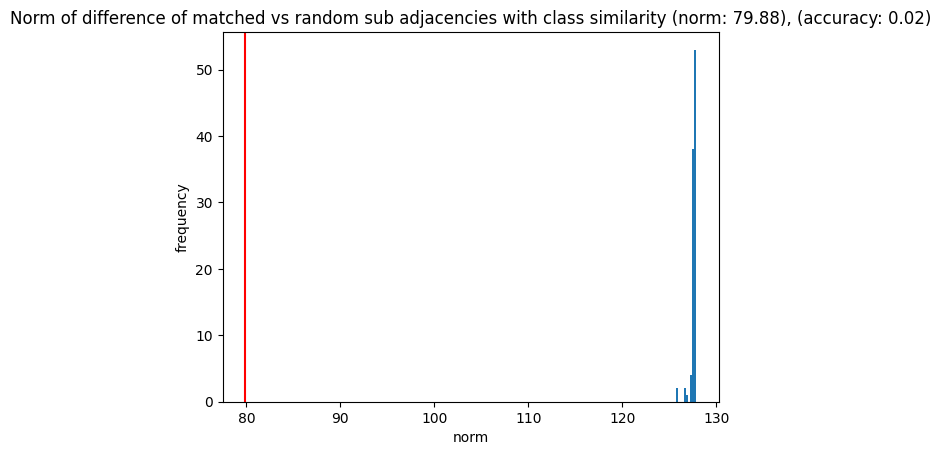

In [182]:
#histogram of WHOLE NADINE CLASS
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_sub_nadine)
ax.axvline(sub_nadine_matched_class_norm_average, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of matched vs random sub adjacencies with class similarity (norm: {:.2f}), (accuracy: {:.2f})".format(sub_nadine_matched_class_norm_average, sub_nadine_matched_class_accuracy_average))

Text(0.5, 1.0, 'Initialized Matched vs Random (Norm: 144.05), (Accuracy: 0.27)')

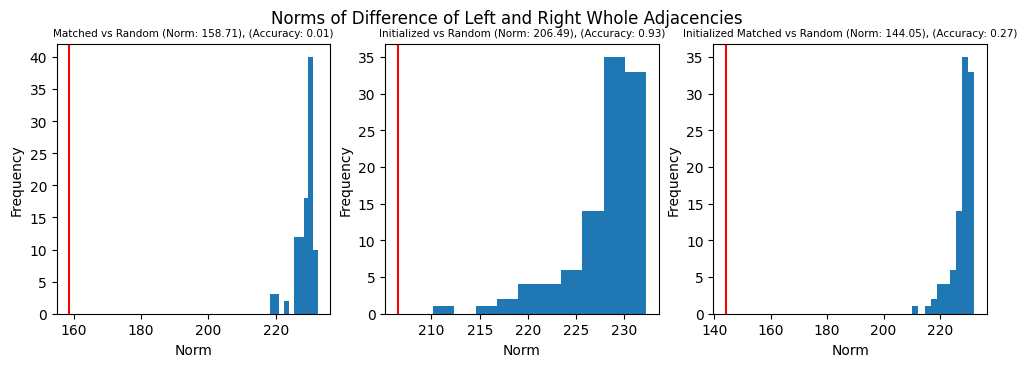

In [131]:
#whole histograms
fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))
fig.suptitle("Norms of Difference of Left and Right Whole Adjacencies")

axes[0].hist(rand_norms_whole)
axes[0].axvline(norm_mean, color="r")
axes[0].set_xlabel("Norm")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Matched vs Random (Norm: {:.2f}), (Accuracy: {:.2f})".format(norm_mean, accuracy_mean), fontsize=7.5)

axes[1].hist(rand_norms_whole_nadine)
axes[1].axvline(diff_whole_to_match_norm_average, color="r")
axes[1].set_xlabel("Norm")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Initialized vs Random (Norm: {:.2f}), (Accuracy: {:.2f})".format(diff_whole_to_match_norm_average, whole_to_match_accuracy_average), fontsize=7.5)

axes[2].hist(rand_norms_whole_nadine)
axes[2].axvline(whole_nadine_matched_norm_average, color="r")
axes[2].set_xlabel("Norm")
axes[2].set_ylabel("Frequency")
axes[2].set_title("Initialized Matched vs Random (Norm: {:.2f}), (Accuracy: {:.2f})".format(whole_nadine_matched_norm_average, whole_nadine_matched_accuracy_average), fontsize=7.5)

Text(0.5, 1.0, 'Norms of Differences of Whole vs Random Adjacencies')

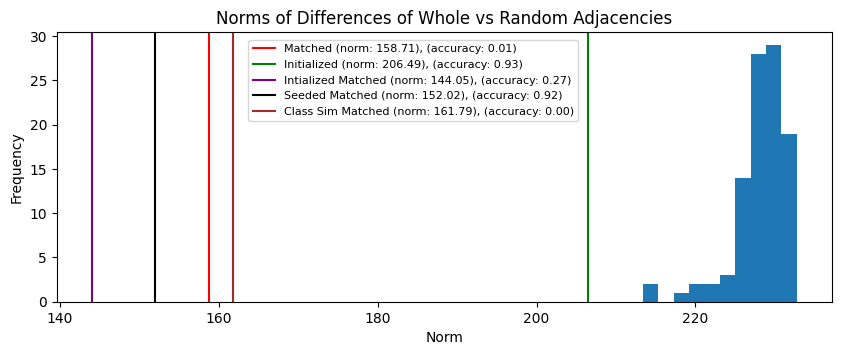

In [229]:
#whole combined histogram

fig, ax = plt.subplots(1, 1, figsize=(10, 3.5))
ax.hist(rand_norms_whole_nadine)
ax.axvline(norm_mean, color="r", label="Matched (norm: {:.2f}), (accuracy: {:.2f})".format(norm_mean, accuracy_mean))
ax.axvline(diff_whole_to_match_norm_average, color="g", label="Initialized (norm: {:.2f}), (accuracy: {:.2f})".format(diff_whole_to_match_norm_average, whole_to_match_accuracy_average))
ax.axvline(whole_nadine_matched_norm_average, color="purple", label="Intialized Matched (norm: {:.2f}), (accuracy: {:.2f})".format(whole_nadine_matched_norm_average, whole_nadine_matched_accuracy_average))
ax.axvline(whole_nadine_matched_seed_norm_average, color="black", label="Seeded Matched (norm: {:.2f}), (accuracy: {:.2f})".format(whole_nadine_matched_seed_norm_average, whole_nadine_matched_seed_accuracy_average))
ax.axvline(whole_nadine_matched_class_norm_average, color="brown", label="Class Sim Matched (norm: {:.2f}), (accuracy: {:.2f})".format(whole_nadine_matched_class_norm_average, whole_nadine_matched_class_accuracy_average))
ax.set_xlabel("Norm")
ax.set_ylabel("Frequency")
ax.legend(bbox_to_anchor=(-0.04, 0.65, 1., 0.5), fontsize=8)
ax.set_title("Norms of Differences of Whole vs Random Adjacencies")

Text(0.5, 1.0, 'Initialized Matched vs Random (norm: 68.44), (accuracy: 0.42)')

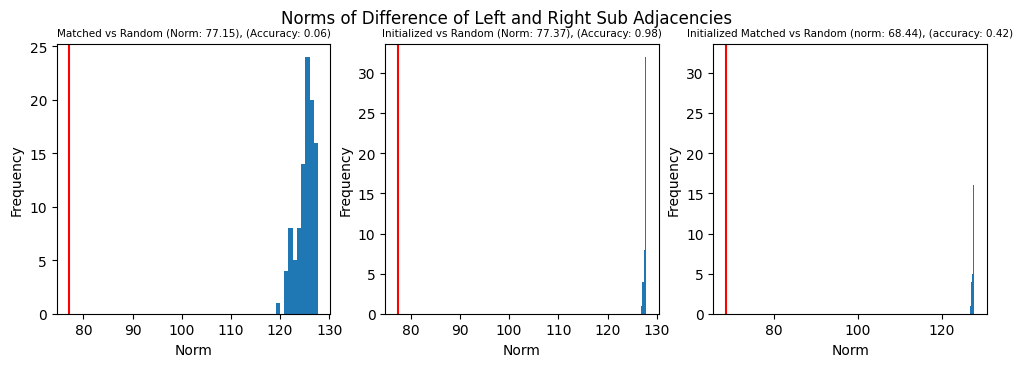

In [132]:
#sub histograms
fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))
fig.suptitle("Norms of Difference of Left and Right Sub Adjacencies")

axes[0].hist(rand_norms)
axes[0].axvline(sub_matched_norm_average, color="r")
axes[0].set_xlabel("Norm")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Matched vs Random (Norm: {:.2f}), (Accuracy: {:.2f})".format(sub_matched_norm_average, sub_matched_accuracy_average), fontsize=7.5)

axes[1].hist(rand_norms_sub_nadine)
axes[1].axvline(diff_sub_to_match_norm_average, color="r")
axes[1].set_xlabel("Norm")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Initialized vs Random (Norm: {:.2f}), (Accuracy: {:.2f})".format(diff_sub_to_match_norm_average, sub_to_match_accuracy_average), fontsize=7.5)

axes[2].hist(rand_norms_sub_nadine)
axes[2].axvline(sub_nadine_matched_norm_average, color="r")
axes[2].set_xlabel("Norm")
axes[2].set_ylabel("Frequency")
axes[2].set_title("Initialized Matched vs Random (norm: {:.2f}), (accuracy: {:.2f})".format(sub_nadine_matched_norm_average, sub_nadine_matched_accuracy_average), fontsize=7.5)

Text(0.5, 1.0, 'Norm of Difference of Sub vs Random Adjacencies')

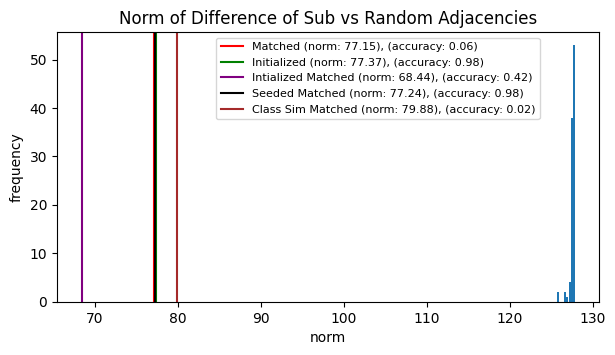

In [237]:
#wsub combined histogram

fig, ax = plt.subplots(1, 1, figsize=(7, 3.5))
ax.hist(rand_norms_sub_nadine)
ax.axvline(sub_matched_norm_average, color="r", label="Matched (norm: {:.2f}), (accuracy: {:.2f})".format(sub_matched_norm_average, sub_matched_accuracy_average))
ax.axvline(diff_sub_to_match_norm_average, color="g", label="Initialized (norm: {:.2f}), (accuracy: {:.2f})".format(diff_sub_to_match_norm_average, sub_to_match_accuracy_average))
ax.axvline(sub_nadine_matched_norm_average, color="purple", label="Intialized Matched (norm: {:.2f}), (accuracy: {:.2f})".format(sub_nadine_matched_norm_average, sub_nadine_matched_accuracy_average))
ax.axvline(sub_nadine_matched_seed_norm_average, color="black", label="Seeded Matched (norm: {:.2f}), (accuracy: {:.2f})".format(sub_nadine_matched_seed_norm_average, sub_nadine_matched_seed_accuracy_average))
ax.axvline(sub_nadine_matched_class_norm_average, color="brown", label="Class Sim Matched (norm: {:.2f}), (accuracy: {:.2f})".format(sub_nadine_matched_class_norm_average, sub_nadine_matched_class_accuracy_average))
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.legend(bbox_to_anchor=(-0.1, 0.5, 1., 0.5), fontsize=8)
ax.set_title("Norm of Difference of Sub vs Random Adjacencies")

- For the cases that I don't run graph matching, when calculating the norm, since the left and right skid list have different dimension, I chop off the last skids of the left list so the left and right lists are the same length and the pairs align
- What is labels in the paired test?